In [1]:
%reset -f

In [2]:
if True == False:
    !pip install --upgrade pip
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    !pip install numba
    !pip install sklearn
    !pip install mediapipe
    !pip install tqdm
    !pip install seaborn
    !pip install -U scikit-learn

In [3]:
import os
import random
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


import torch
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import cv2
import mediapipe as mp
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
#Seed data, to ensure that between runs, the results would not differ
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("Using {} device".format(device))

Using cuda device


In [6]:
#A function to pad the data array with 0s
def pad_array(input_array, new_shape):
    first, second = np.shape(input_array)
    output_array = np.zeros(new_shape)
    output_array[0:first, 0:second] = input_array
    return output_array

In [7]:
#Normalise function to normalise the keypoint data so it's easier for the network
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(10, 11))

#Numeric labeller
label_encoder = sklearn.preprocessing.LabelEncoder()

In [8]:
#Mediapipe parameters and variables
min_detect = 0.7 #non-default
min_track = 0.7 #non-default
segmentation = False #default
model_complex = 1 #default

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [9]:
def extract_keypoints(image, pose):
    # Convert image to RGB and process with pose
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw keypoints and connections on the image
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # Extract keypoints if available
    if results.pose_landmarks:
        keypoints = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_landmarks.landmark]).flatten()
        return image, keypoints
    else:
        return image, None

In [10]:
def process_dataset(data_directory=os.getcwd() + "/data/", save_frames=False):
    frame_array = []
    fps_array = []
    class_names = []
    full_file_names = []

    if save_frames:
        frame_folder = "/frames_" + str(min_detect) + "_" + str(min_track) + "_" + str(segmentation) + "_" + str(model_complex) + "/"
        frame_path = os.getcwd() + frame_folder
        if not os.path.exists(frame_path):
            os.mkdir(frame_path)

    with mp.solutions.pose.Pose(min_detection_confidence=min_detect, min_tracking_confidence=min_track, model_complexity=model_complex, enable_segmentation=segmentation) as pose:
        # Iterate through each class directory with a progress bar
        for class_name in tqdm(os.listdir(data_directory), desc="Processing classes"):
            class_path = os.path.join(data_directory, class_name)
            if os.path.isdir(class_path):
                # Process each video in class directory with a progress bar
                for video_file in tqdm(os.listdir(class_path), desc=f"Processing videos in {class_name}"):
                    video_path = os.path.join(class_path, video_file)
                    cap = cv2.VideoCapture(video_path)
                    count = 0

                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break

                        if save_frames:
                            image, _ = extract_keypoints(frame, pose)
                            image_file_name = os.path.join(frame_path, f"{Path(video_file).stem}_{count}.jpeg")
                            cv2.imwrite(image_file_name, image)
                        
                        count += 1

                    frame_array.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
                    fps_array.append(cap.get(cv2.CAP_PROP_FPS))
                    class_names.append(class_name)
                    full_file_names.append(video_path)  # Storing full file path
                    cap.release()
                    cv2.destroyAllWindows()

    return frame_array, fps_array, class_names, full_file_names

In [11]:
def tensor_label_maker(video_list, shape):
    video_array = []
    label_array = []

    with mp_pose.Pose(min_detection_confidence=min_detect, min_tracking_confidence=min_track,
                      model_complexity=model_complex, enable_segmentation=segmentation) as pose:
        
        for video_path in tqdm(video_list):
            cap = cv2.VideoCapture(video_path)
            keypoints_list = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                _, keypoints = extract_keypoints(frame, pose)
                if keypoints is not None:
                    keypoints_list.append(keypoints)
                else:
                    continue

            if keypoints_list:  # Only proceed if keypoints are found
                video = np.stack(keypoints_list, axis=0)
                video = scaler.fit_transform(video)
                video = pad_array(video, shape)  # Pads to largest video
                video = np.expand_dims(video, axis=0)  # Turns (frame_size, keypoints_length) into (1, frame_size, keypoints_length)
                video_array.append(video)  # Add current video to list
                label = os.path.basename(os.path.dirname(video_path))  # Extract class name as label
                numeric_label = label_encoder.transform([label])[0]
                label_array.append(numeric_label)

            cap.release()
            cv2.destroyAllWindows()

        tensor = np.vstack(video_array) if video_array else np.array([])
        return tensor, np.array(label_array)


In [12]:
class KeypointDataset(torch.utils.data.Dataset):
    def __init__(self, keypoints, labels, transform=None):
        self.keypoints = np.array(keypoints)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.keypoints)

    def __getitem__(self, idx):
        keypoints = torch.tensor(self.keypoints[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            keypoints = self.transform(keypoints)
        return keypoints, label

In [13]:
video_data = process_dataset(os.getcwd() + r"/data")
files = video_data[3]
all_classes = video_data[2]
class_names = np.unique(video_data[2])
number_of_classes = len(class_names)
frame_limit = max(video_data[0])
fps_array = video_data[1]
fps_min = min(fps_array)
fps_max = max(fps_array)
shape = list((len(files), frame_limit, 132)) #number of videos, number of frames, number of keypoints
label_map = {label:num for num, label in enumerate(class_names)}
numeric_labels = label_encoder.fit_transform(all_classes)

I0000 00:00:1705524357.369874  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524357.446376  113166 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
Processing classes: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


In [14]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

In [15]:
train_files, test_files, train_targets, test_targets = sklearn.model_selection.train_test_split(files, numeric_labels, test_size=1 - train_ratio, random_state = seed,  stratify = numeric_labels)
valid_files, test_files, valid_targets, test_targets = sklearn.model_selection.train_test_split(test_files,test_targets, test_size = test_ratio / (test_ratio + validation_ratio), random_state = seed, stratify = test_targets)

In [16]:
X_train, y_train = tensor_label_maker(train_files, shape[1:])
X_val, y_val = tensor_label_maker(valid_files, shape[1:])
X_test, y_test = tensor_label_maker(test_files, shape[1:])

I0000 00:00:1705524362.141561  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524362.212981  114616 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
100%|██████████| 144/144 [03:46<00:00,  1.57s/it]
I0000 00:00:1705524588.783634  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524588.872091  116234 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
100%|██████████| 18/18 [00:22<00:00,  1.23s/it]
I0000 00:00:1705524610.987365  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524611.089971  116393 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
100%|██████████| 18/18 [00:26<00:00,  1.50s/it]


In [17]:
# Create dataset instances
train_dataset = KeypointDataset(X_train, y_train)
val_dataset = KeypointDataset(X_val, y_val)
test_dataset = KeypointDataset(X_test, y_test)

In [18]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, number_of_classes, shape):
        super(NeuralNetwork, self).__init__()
        self.num_frames = shape[1]  # 51 frames
        self.num_keypoints = shape[2]  # 132 keypoints

        self.conv1 = torch.nn.Conv1d(in_channels=self.num_keypoints, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.lstm1 = torch.nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.norm1 = torch.nn.BatchNorm1d(num_features=128)
        self.conv2 = torch.nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.lstm2 = torch.nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.norm2 = torch.nn.BatchNorm1d(num_features=64)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding='same')
        self.lstm3 = torch.nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.norm3 = torch.nn.BatchNorm1d(num_features=32)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(32 * self.num_frames, number_of_classes)  # Adjust based on LSTM output

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjusting the input for Conv1D: [batch, keypoints, frames]
        x = torch.tanh(self.conv1(x))
        x = x.permute(0, 2, 1)  # Adjusting for LSTM: [batch, frames, features]
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Adjusting for BatchNorm1D: [batch, features, frames]
        x = self.norm1(x)
        x = torch.tanh(self.conv2(x))
        x = x.permute(0, 2, 1)  # Adjusting for LSTM
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)  # Adjusting for BatchNorm1D
        x = self.norm2(x)
        x = torch.tanh(self.conv3(x))
        x = x.permute(0, 2, 1)  # Adjusting for LSTM
        x, _ = self.lstm3(x)
        x = x.permute(0, 2, 1)  # Adjusting for BatchNorm1D
        x = self.norm3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return torch.softmax(x, dim=1)

# Instantiate the model with the number of classes and shape
model = NeuralNetwork(number_of_classes, shape).to(device)
print(model)


NeuralNetwork(
  (conv1): Conv1d(132, 128, kernel_size=(5,), stride=(1,), padding=same)
  (lstm1): LSTM(128, 128, batch_first=True)
  (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (lstm2): LSTM(64, 64, batch_first=True)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(1,), stride=(1,), padding=same)
  (lstm3): LSTM(32, 32, batch_first=True)
  (norm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6016, out_features=3, bias=True)
)


In [19]:
# Model compilation equivalent
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [20]:
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [21]:
def validate_model(val_loader, model, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [22]:
def test_model(test_loader, model, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


In [23]:
batch_size = train_dataset.keypoints.shape[0]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
train_losses = []
val_losses = []

# Example of training and validation for a number of epochs
num_epochs = 2000

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_accuracy = train_model(train_loader, model, criterion, optimizer, device)
    print(f'Epoch {epoch+1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    train_losses.append(train_loss)
    val_loss, val_accuracy = validate_model(val_loader, model, criterion, device)
    print(f'Epoch {epoch+1} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    val_losses.append(val_loss)

# Test the model after training is completed
test_loss, test_accuracy = test_model(test_loader, model, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/2000


/home/sammy/miniconda3/envs/posturepytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1 Training Loss: 1.1447, Training Accuracy: 29.86%
Epoch 1 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 2/2000
Epoch 2 Training Loss: 1.1285, Training Accuracy: 31.25%
Epoch 2 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 3/2000
Epoch 3 Training Loss: 1.1137, Training Accuracy: 33.33%
Epoch 3 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 4/2000
Epoch 4 Training Loss: 1.1012, Training Accuracy: 35.42%
Epoch 4 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 5/2000
Epoch 5 Training Loss: 1.0905, Training Accuracy: 46.53%
Epoch 5 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 6/2000
Epoch 6 Training Loss: 1.0815, Training Accuracy: 49.31%
Epoch 6 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 7/2000
Epoch 7 Training Loss: 1.0740, Training Accuracy: 50.69%
Epoch 7 Validation Loss: 1.0987, Validation Accuracy: 33.33%
Epoch 8/2000
Epoch 8 Training Loss: 1.0675, Training Accuracy: 48.61%
Epoch 8 Validation Loss: 1

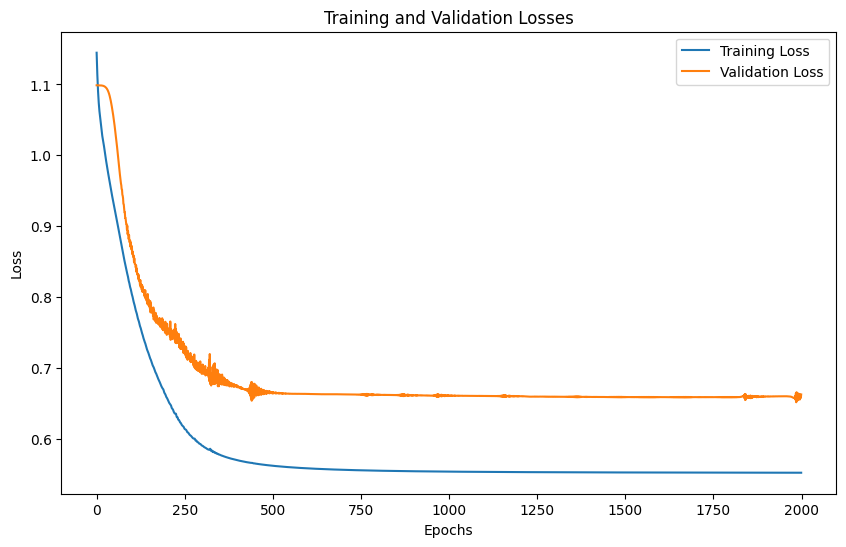

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [26]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [27]:
model = NeuralNetwork(number_of_classes, shape).to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Rep Counter

In [28]:
def Rep_Counter(file_array, index, output_dir, log_output_filename, model, device):
    log = open(output_dir + log_output_filename, "a", encoding="utf-8")
    print("#############################################################", file=log)
    filename = Path(file_array[index])

    default_font = cv2.FONT_HERSHEY_SIMPLEX
    class_colours = [] 
    random.seed(seed)
    for i in class_names:
        B = random.randint(0, 255)
        G = random.randint(0, 255)
        R = random.randint(0, 255)
        colour = tuple([B, G, R])
        class_colours.append(colour)
        
    sequence = []
    logger = [] #sequential log, gives exact order
    predictions = []
    
    graph_data = [[] for i in range(0, len(class_names))]
    
    threshold = 0.99
    count = 1
    cap = cv2.VideoCapture(file_array[index])
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(output_dir + filename.name, fourcc, fps, (width, height))

    mp_pose = mp.solutions.pose
    with mp_pose.Pose(min_detection_confidence=min_detect, min_tracking_confidence=min_track,
                      model_complexity=model_complex, enable_segmentation=segmentation) as pose:
        while cap.isOpened():
            number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            count += 1
            ret, frame = cap.read()

            if not ret:
                break

            exact_time_in_seconds = round(count/fps, 2)

            # Extract keypoints using your custom function
            image, keypoints = extract_keypoints(frame, pose)
            
            if keypoints is None:
                continue
            
            sequence.append(keypoints)
            sequence_np = np.array(sequence)
            sequence_np = scaler.fit_transform(sequence_np)
            sequence_np = pad_array(sequence_np, shape[1:])
            sequence_tensor = torch.tensor(sequence_np, dtype=torch.float32).unsqueeze(0)
            sequence_tensor = sequence_tensor.to(device)

            with torch.no_grad():
                model.eval()
                output = model(sequence_tensor)
                result = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]

            for i in range(len(class_names)):
                graph_data[i].append(result[i])
            
            predicted_class_index = np.argmax(result)                 
            predicted_class_percentage = result[predicted_class_index]
            predicted_class_percentage_rounded = round(predicted_class_percentage, 2)
            predicted_class_name = class_names[predicted_class_index]
            predictions.append(predicted_class_index)

            if np.unique(predictions[-10:])[0] == predicted_class_index:
                if predicted_class_percentage > threshold:   
                    if len(logger) > 0:
                        if predicted_class_name != logger[-1][0]:
                            logger.append([predicted_class_name, exact_time_in_seconds, predicted_class_percentage_rounded])
                    else:
                        logger.append([predicted_class_name, exact_time_in_seconds, predicted_class_percentage_rounded])

            # Probability boxes for each class
            for class_index, probability in enumerate(result):
                start_point = (0, 60 + class_index * 40)
                end_point = (int(probability * 100), 90 + class_index * 40)
                colour = class_colours[class_index]
                thickness = -1
                cv2.rectangle(image, start_point, end_point, colour, thickness)

                text = "{}:{}%".format(class_names[class_index], int(probability*100))
                org = (0, 85 + class_index * 40)
                font_scale = 1
                colour = (255,255,255)
                thickness = 2
                line_type = cv2.LINE_AA
                cv2.putText(image, text, org, default_font, font_scale, colour, thickness, line_type)
            
            # Repetition count
            move_count_array = [0] * len(class_names)
            if len(logger) > 0:
                for log_value in logger:
                    index_to_increment = label_map.get(log_value[0])
                    move_count_array[index_to_increment] += 1

            # Display logger text
            text = "{}".format(logger)
            org = (3, 30)
            font_scale = 0.6
            colour = (255,255,255)
            thickness = 2
            line_type = cv2.LINE_AA
            cv2.putText(image, text, org, default_font, font_scale, colour, thickness, line_type)
            cv2.imshow("Rep-Tracker", image)
            out.write(image)
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break

        count_array = [predictions.count(i) for i in range(len(class_names))]
        
        # Log output
        print("Video {}, {}".format(index+1,filename.name), file=log)
        print("###Repetition Counter###", file=log)
        for i in range(len(class_names)):
            print("{}={}".format(class_names[i], move_count_array[i]), file=log)
            
        print("###Frames###", file=log)
        for i in range(len(class_names)):
            print("{}={}".format(class_names[i], count_array[i]), file=log)
        
        print("###Logger###", file=log)
        print(str(logger), file=log)
            
        print("Readable Frames: {}/{}".format(len(graph_data[0]), number_of_frames), file=log)
        print("Estimate: \"{}\" with {}/{} frames.".format(class_names[np.argmax(count_array)], np.max(count_array), number_of_frames), file=log)
        cap.release()
        out.release()
        cv2.destroyAllWindows()

    # Plotting graph
    plt.figure(figsize=(20, 16))    
    for i in range(len(class_names)):
        plt.plot(graph_data[i], label=class_names[i])
        
    plt.title("Graph for {}".format(filename.name))
    plt.xlabel("Frame Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(output_dir+filename.stem)
    return np.argmax(count_array)

In [29]:
def rep_counter_accuracy(file_list, log_output_filename):
    results = []
    output = os.getcwd() + r"/results/"
    
    if not os.path.exists(output):
        os.mkdir(output)
    
    for index in range(len(file_list)):
        results.append(Rep_Counter(test_files, index, output, log_output_filename, model, device))
    return results 

In [30]:
def similarity(labels, outputs):
    count = 0
    for index in range(len(labels)):
        if labels[index] == outputs[index]:
            count += 1
    return (count/len(labels))*100

### Rep Counter Testing

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
I0000 00:00:1705524727.921867  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524728.027809  116746 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
I0000 00:00:1705524731.086822  113095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705524731.161074  116770 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 

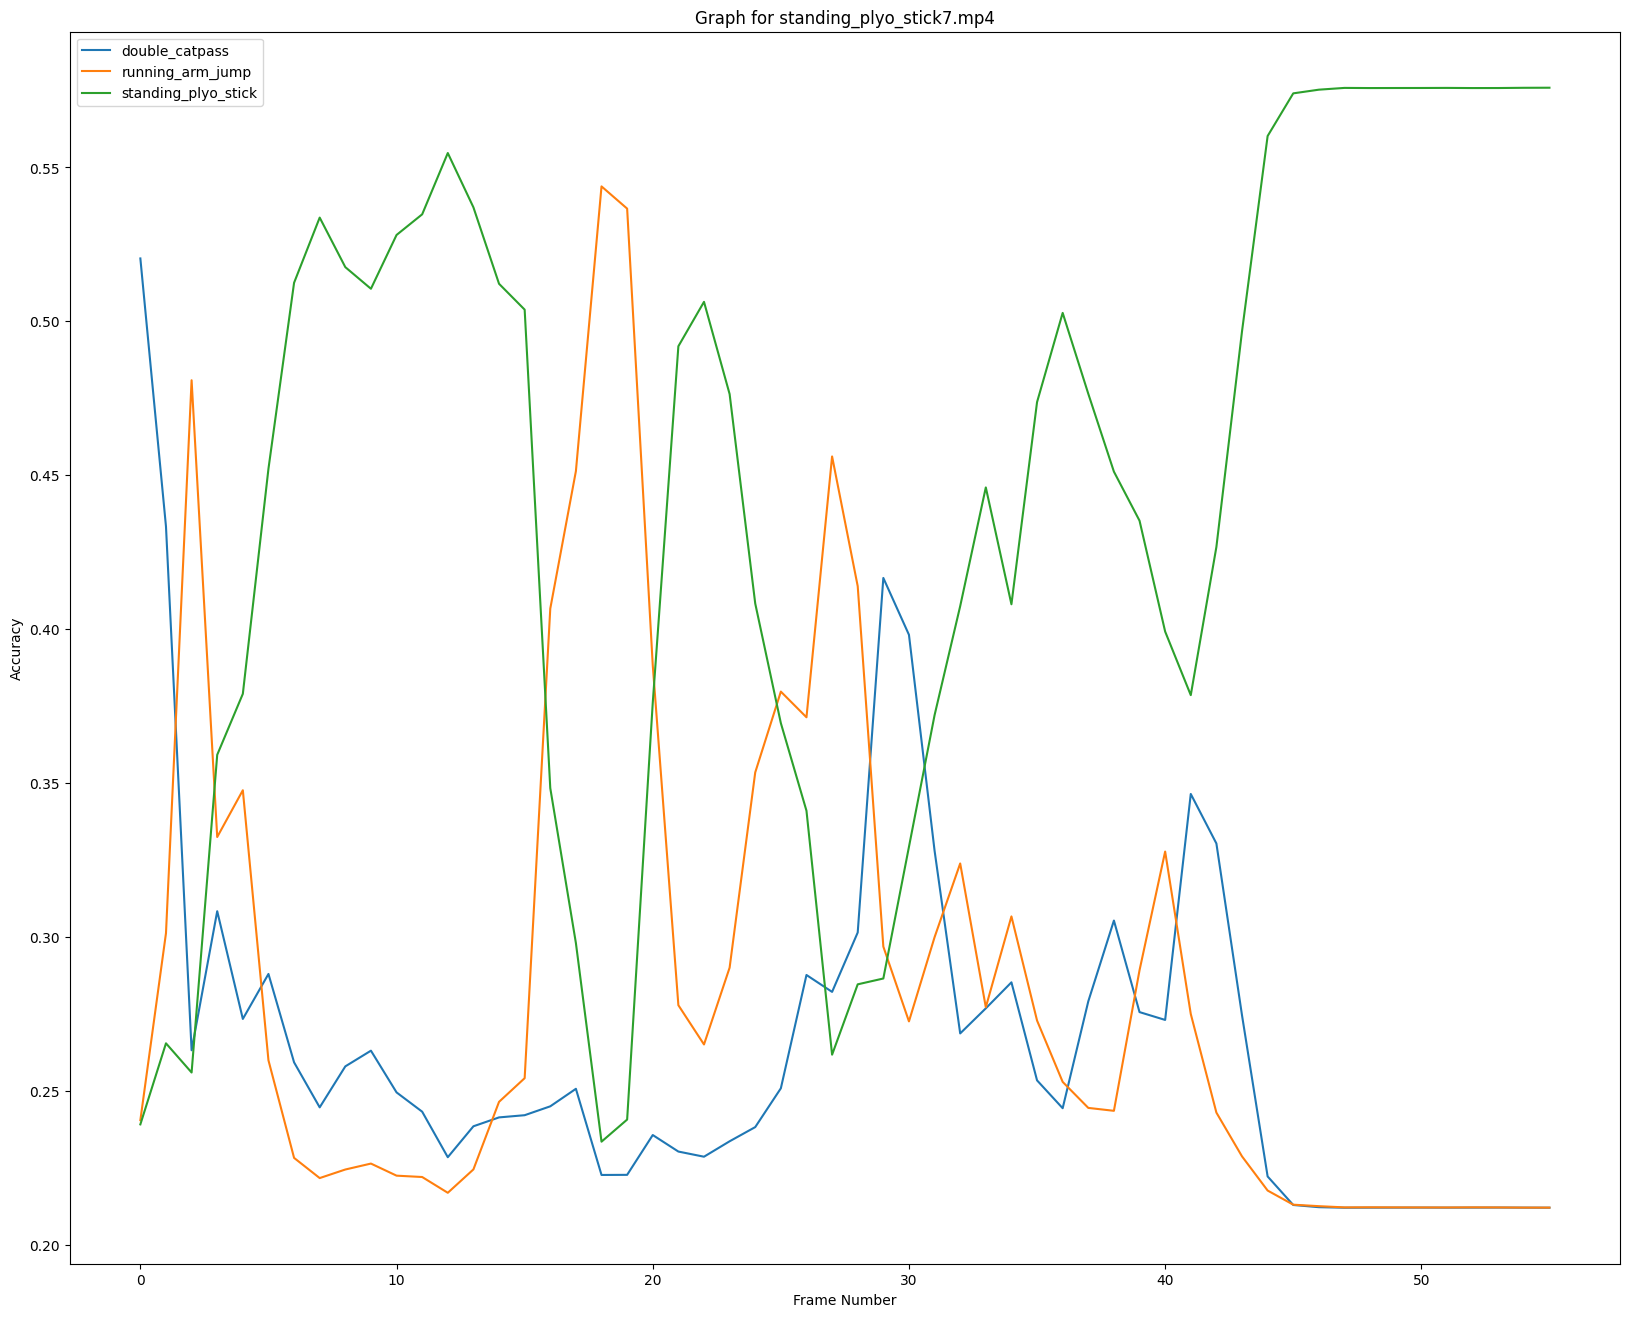

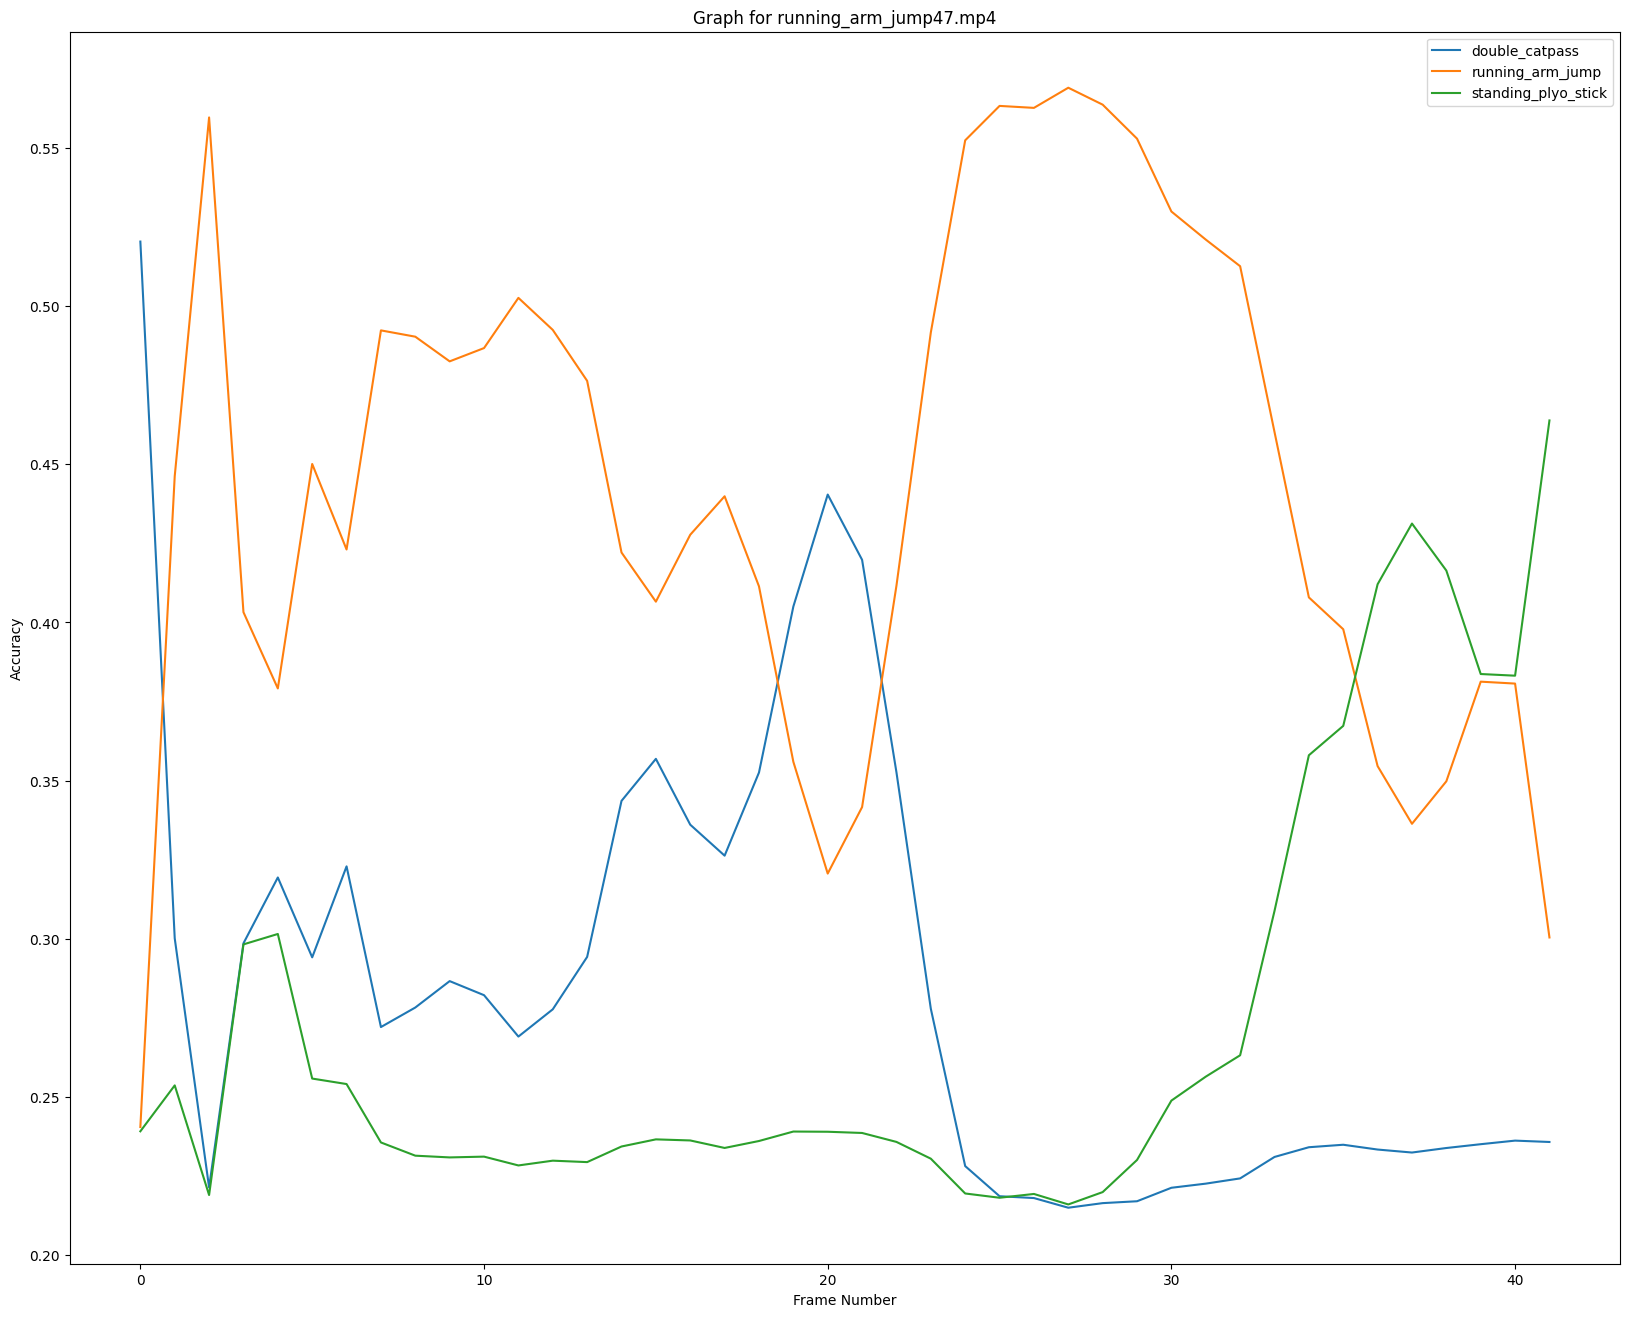

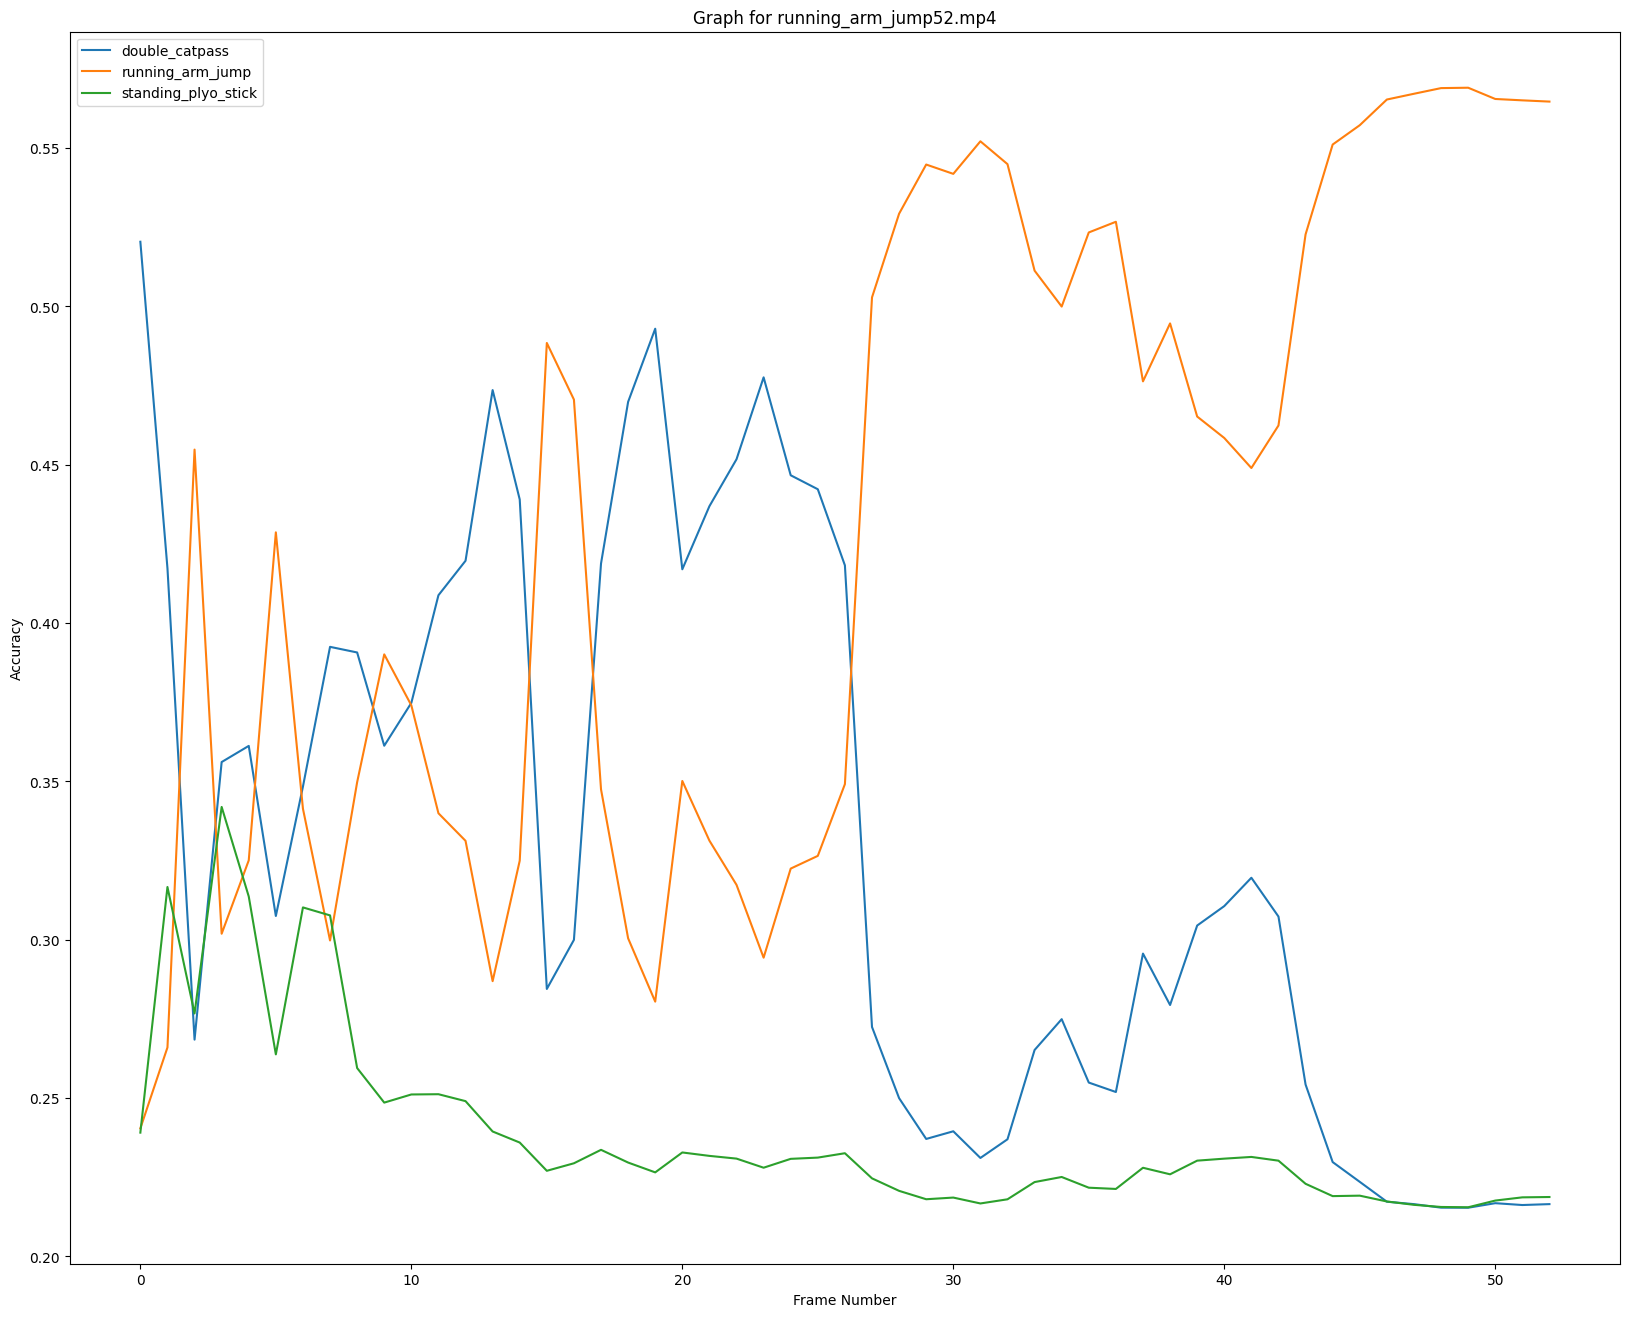

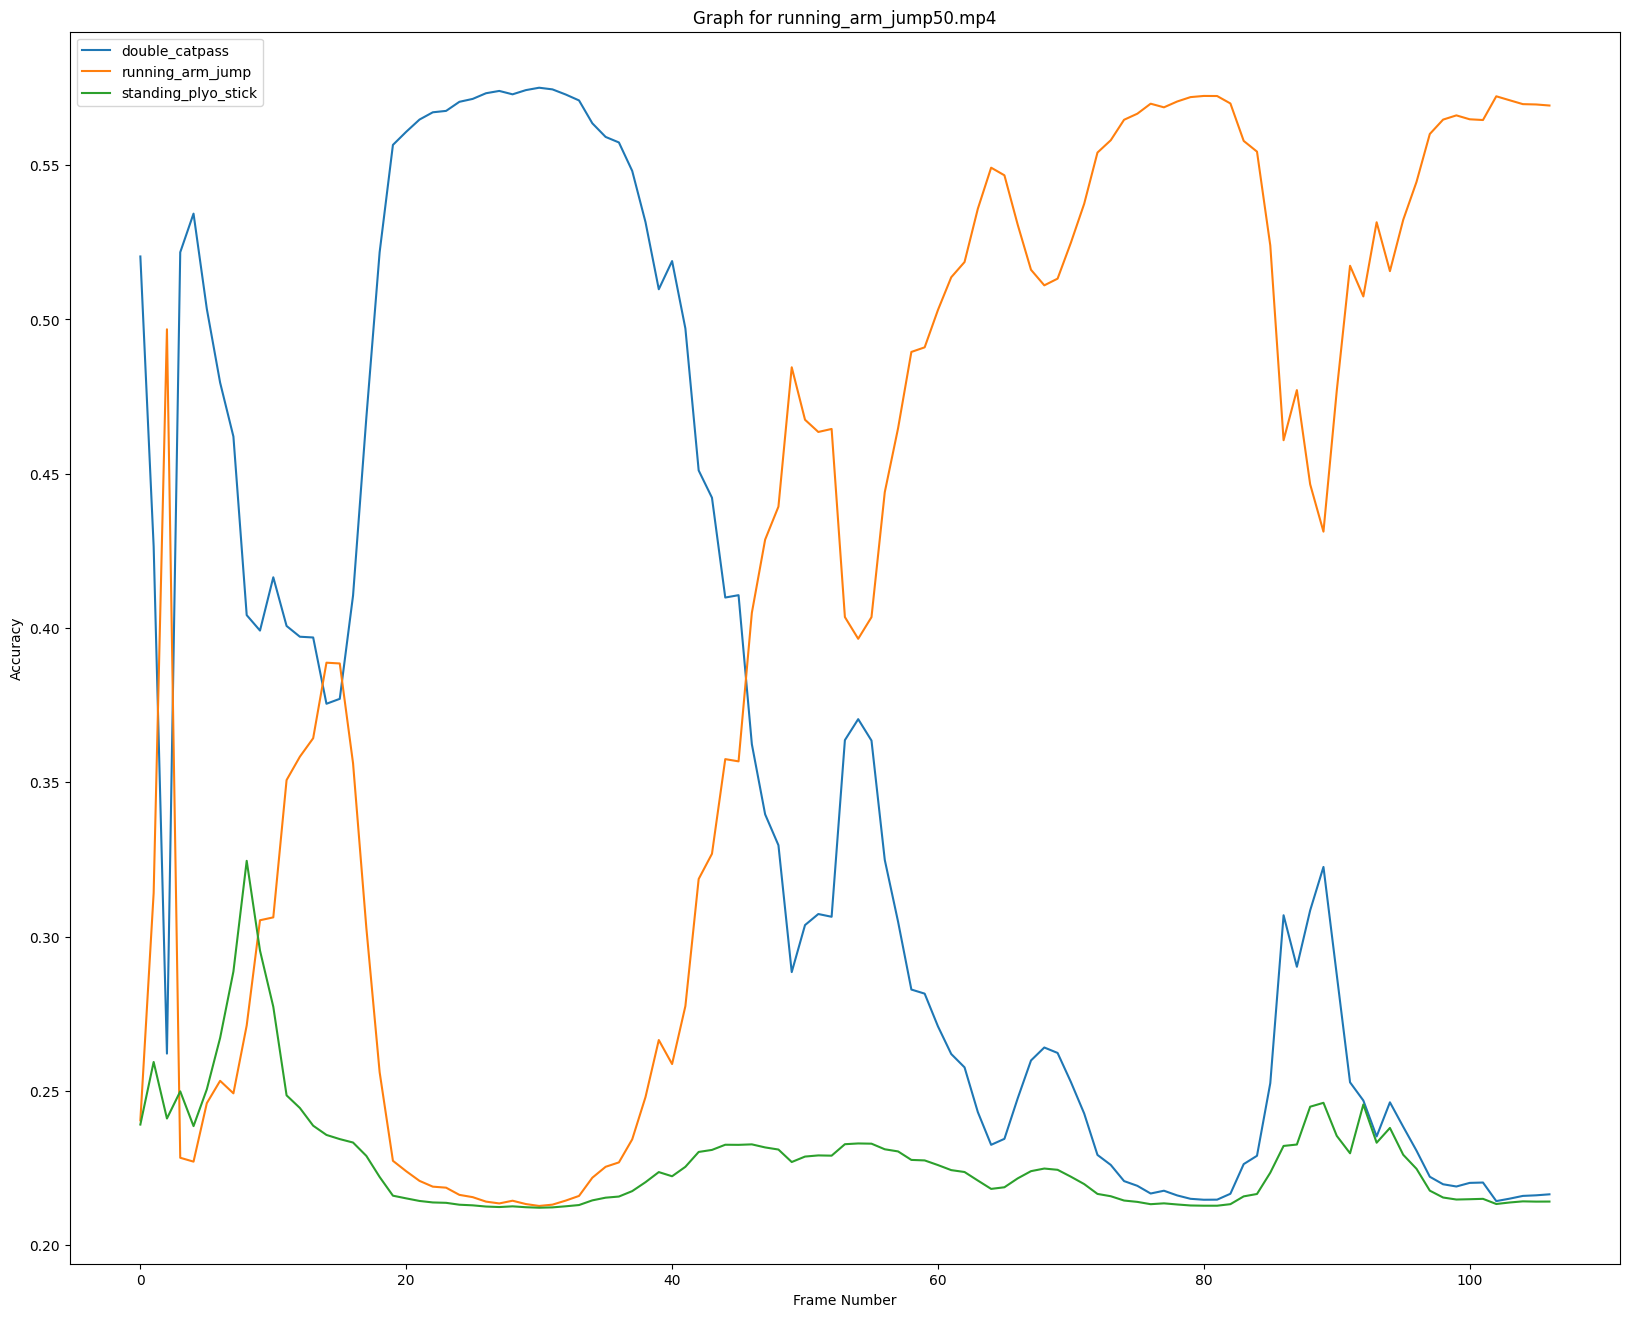

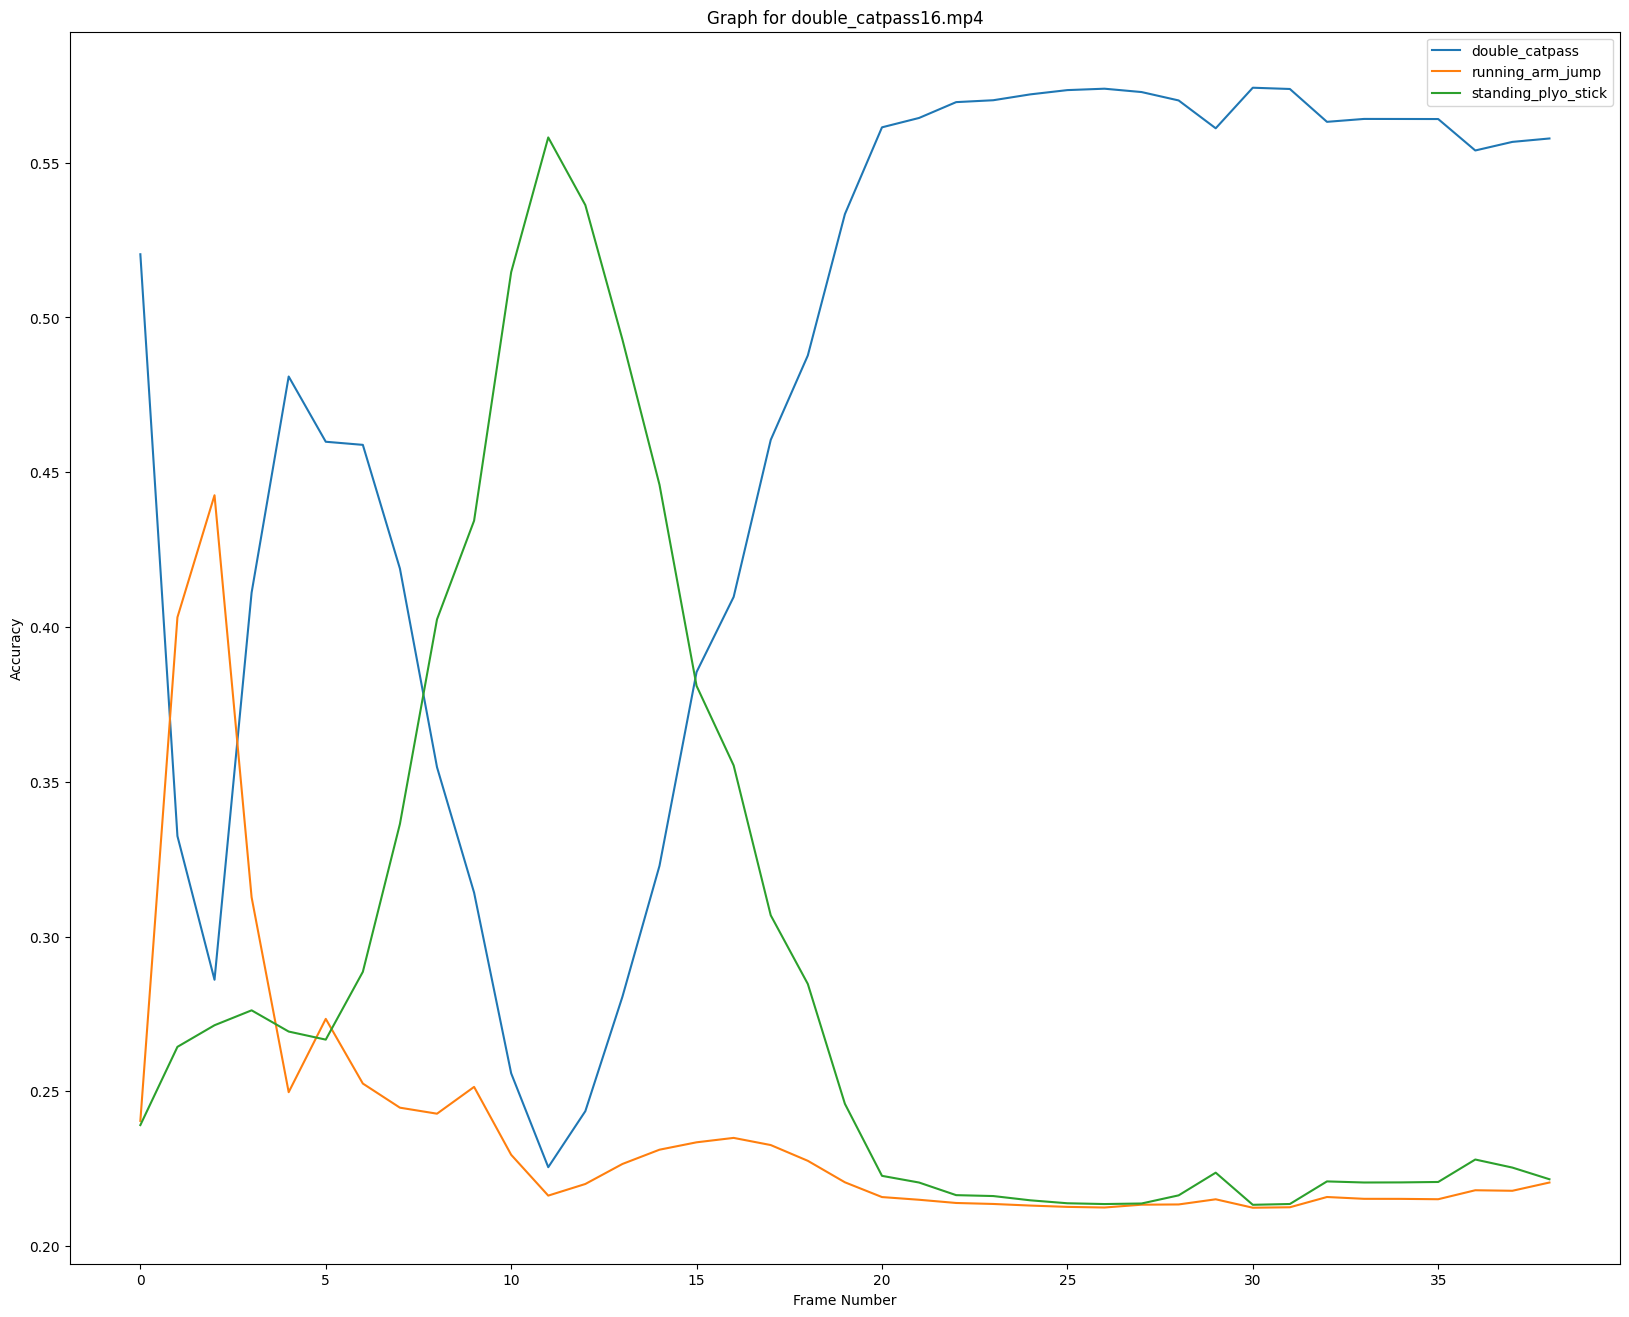

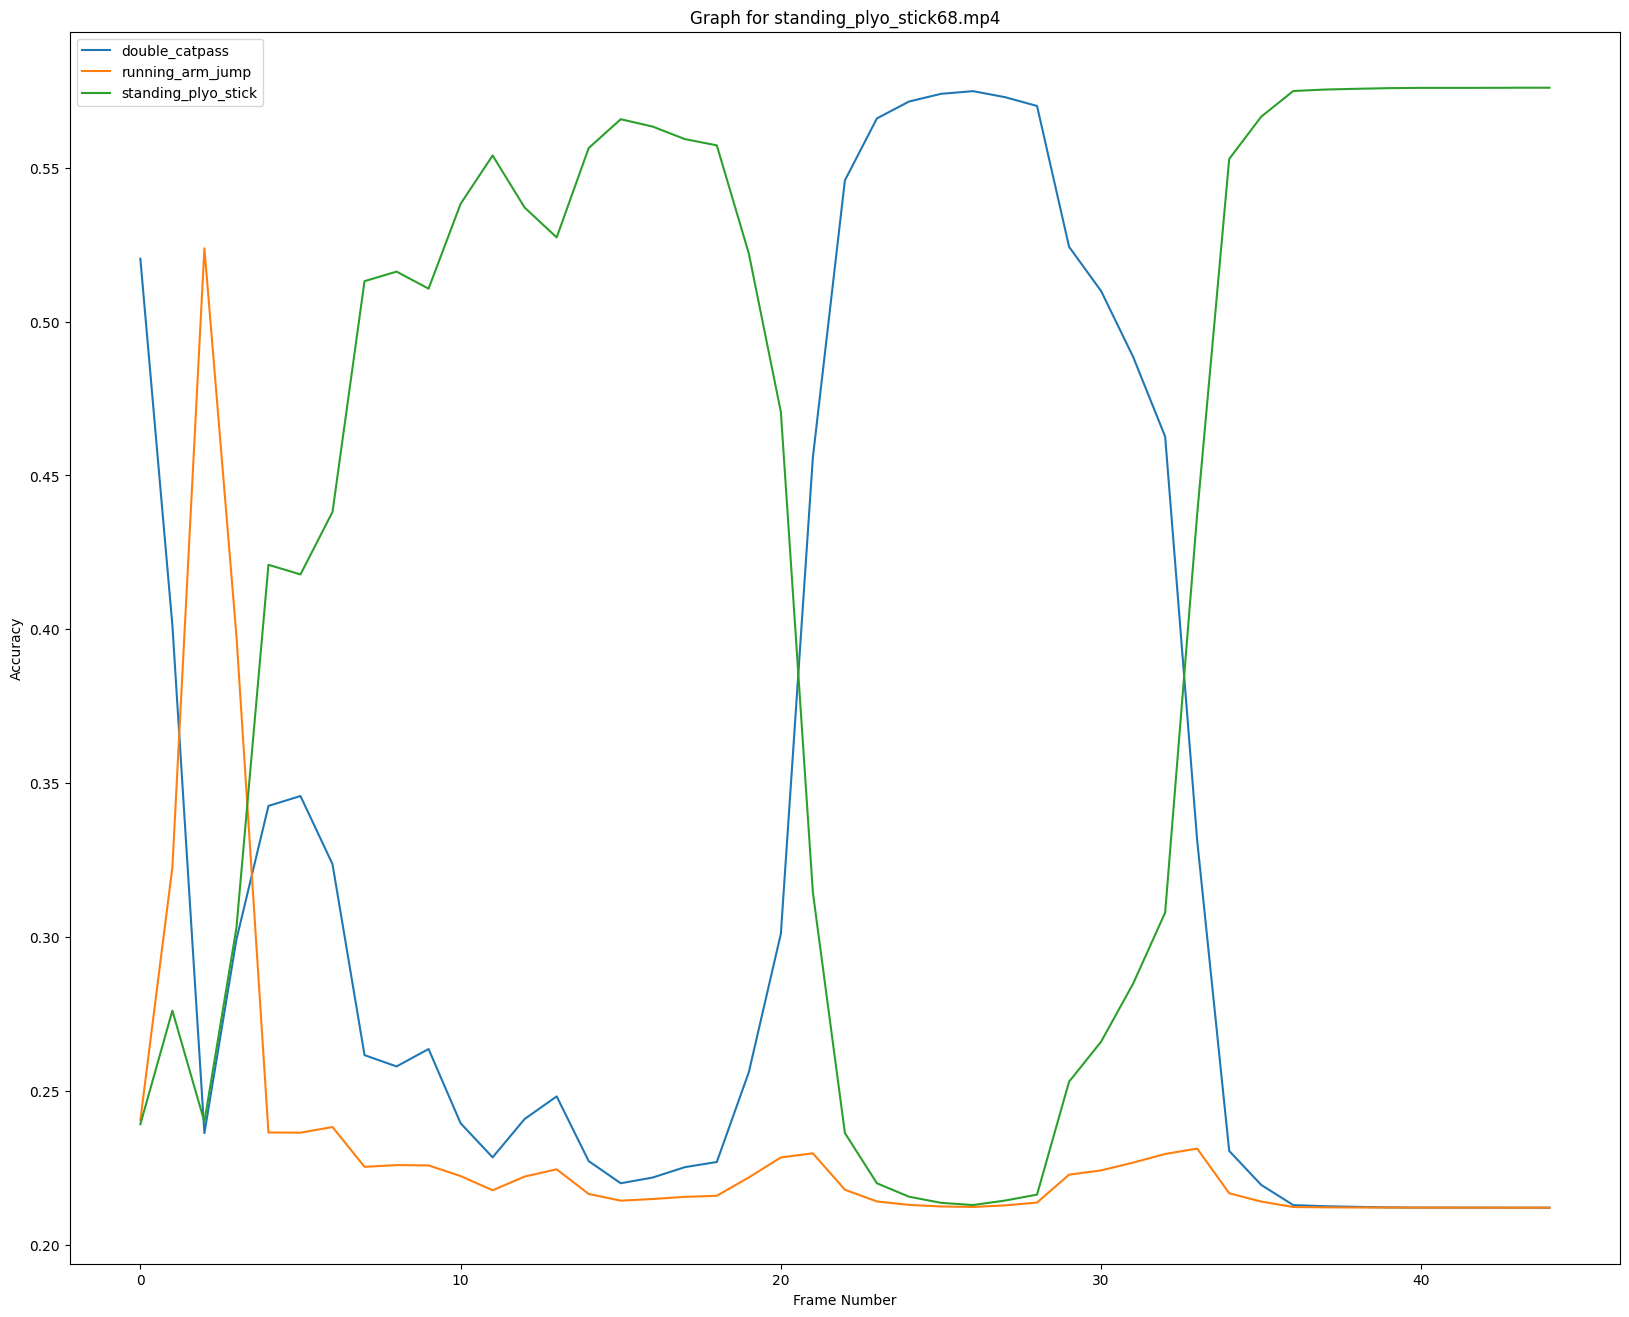

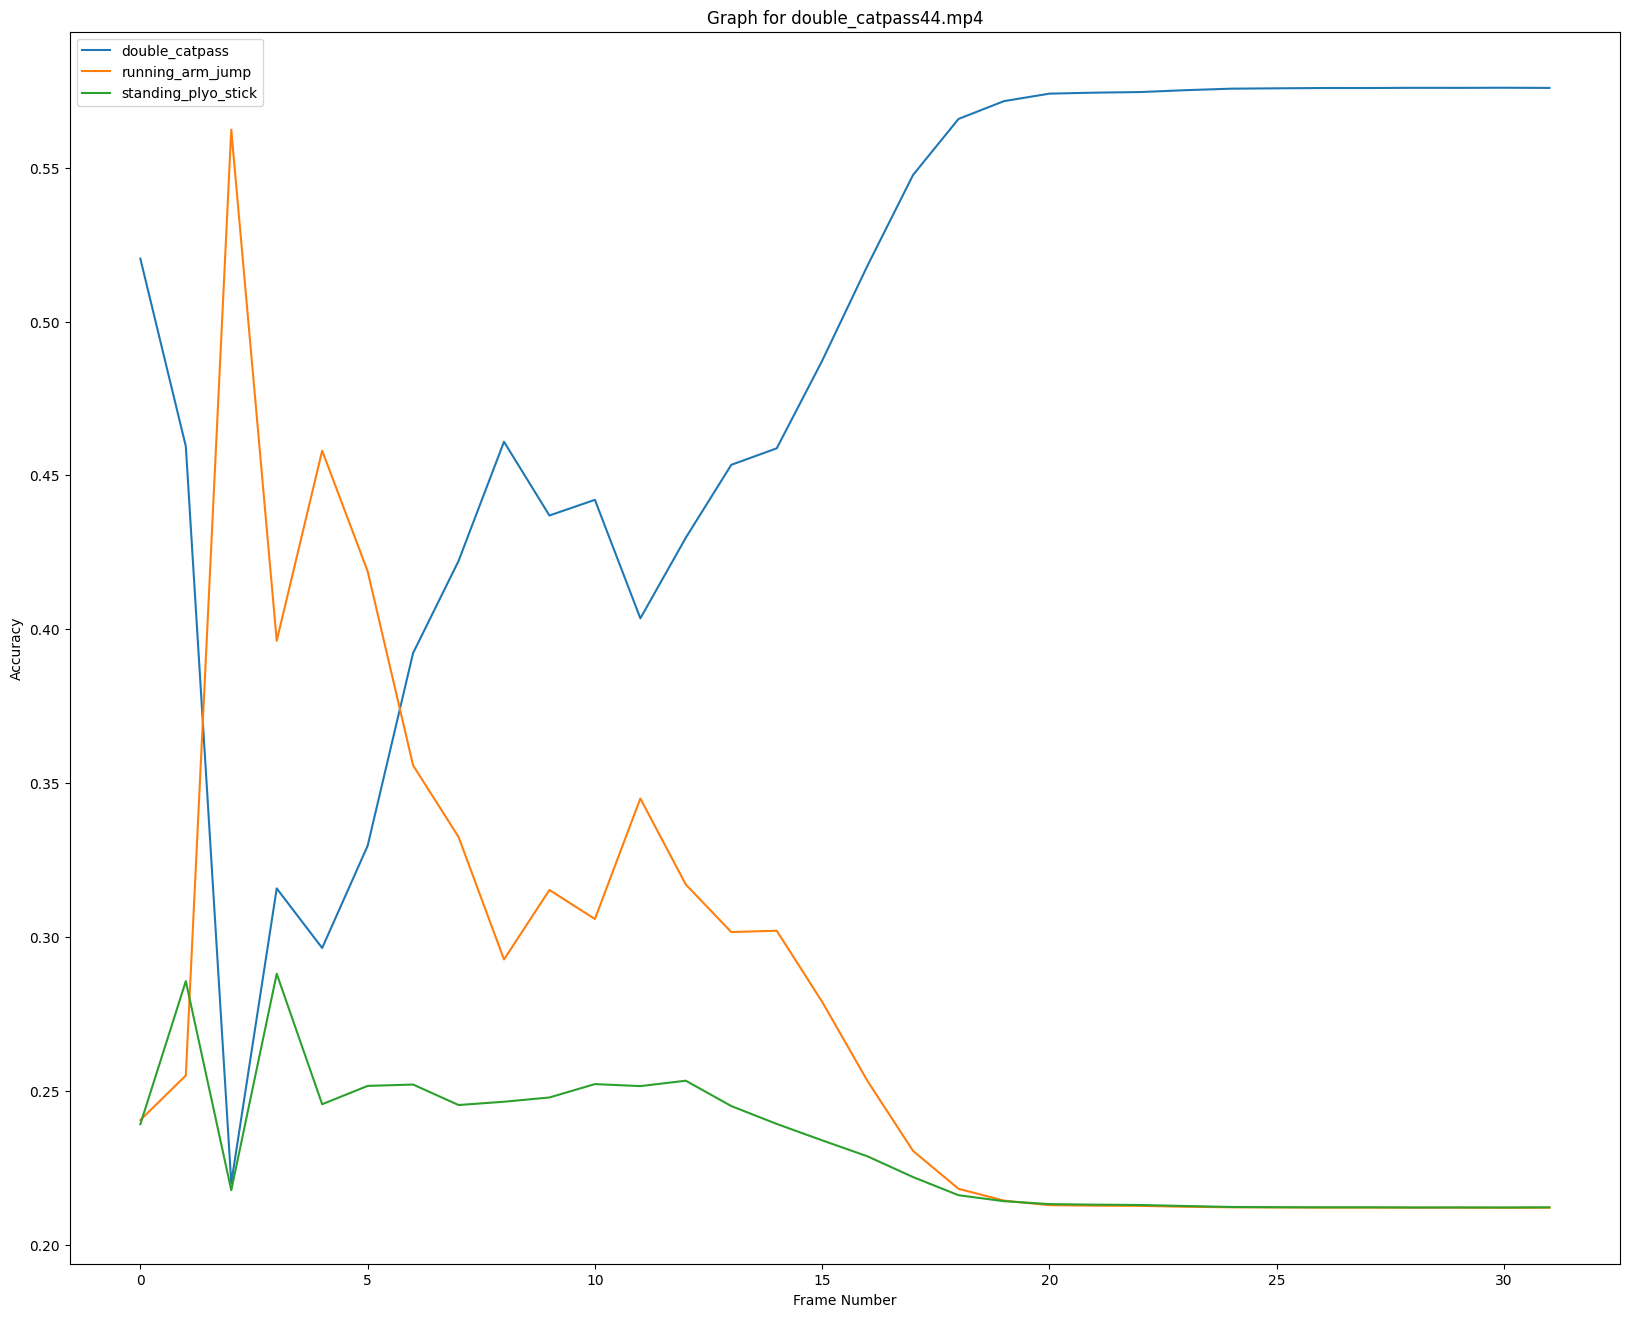

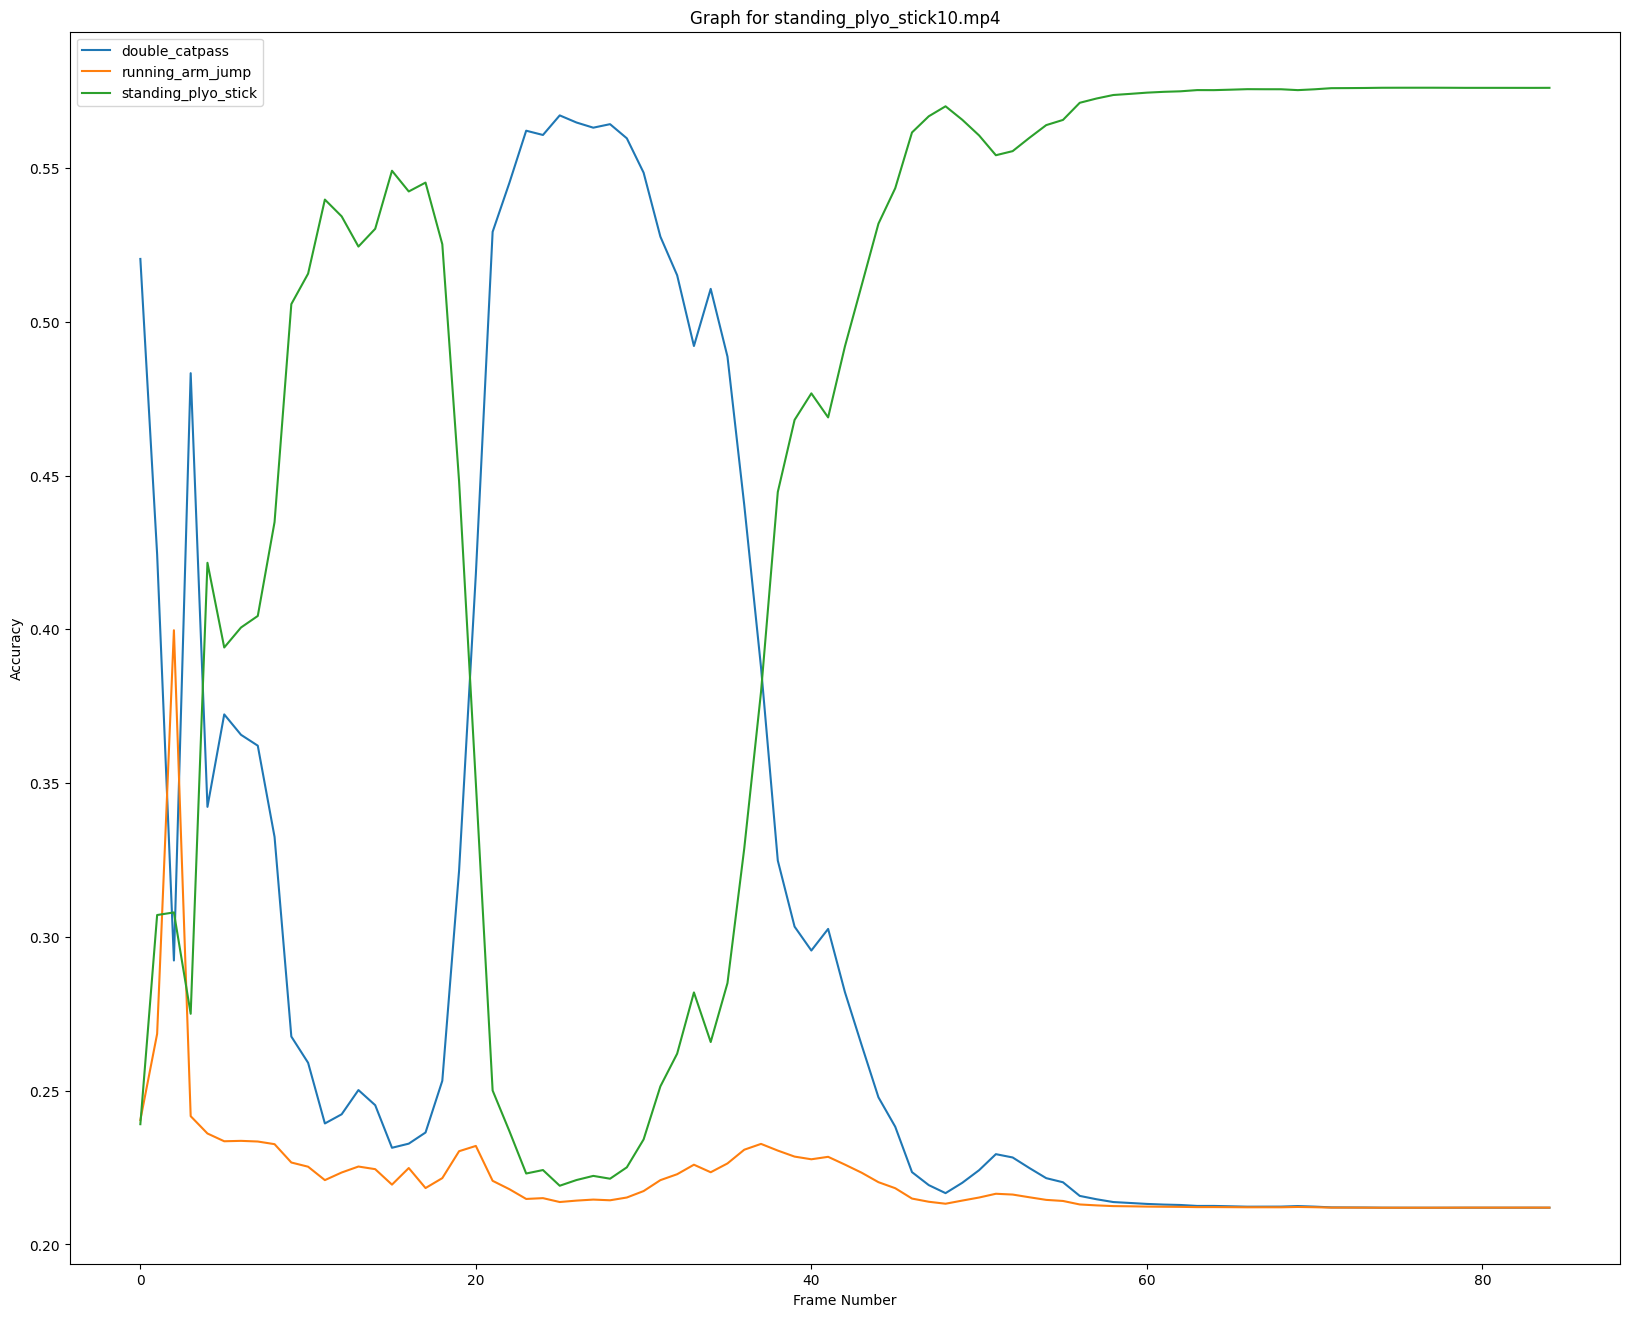

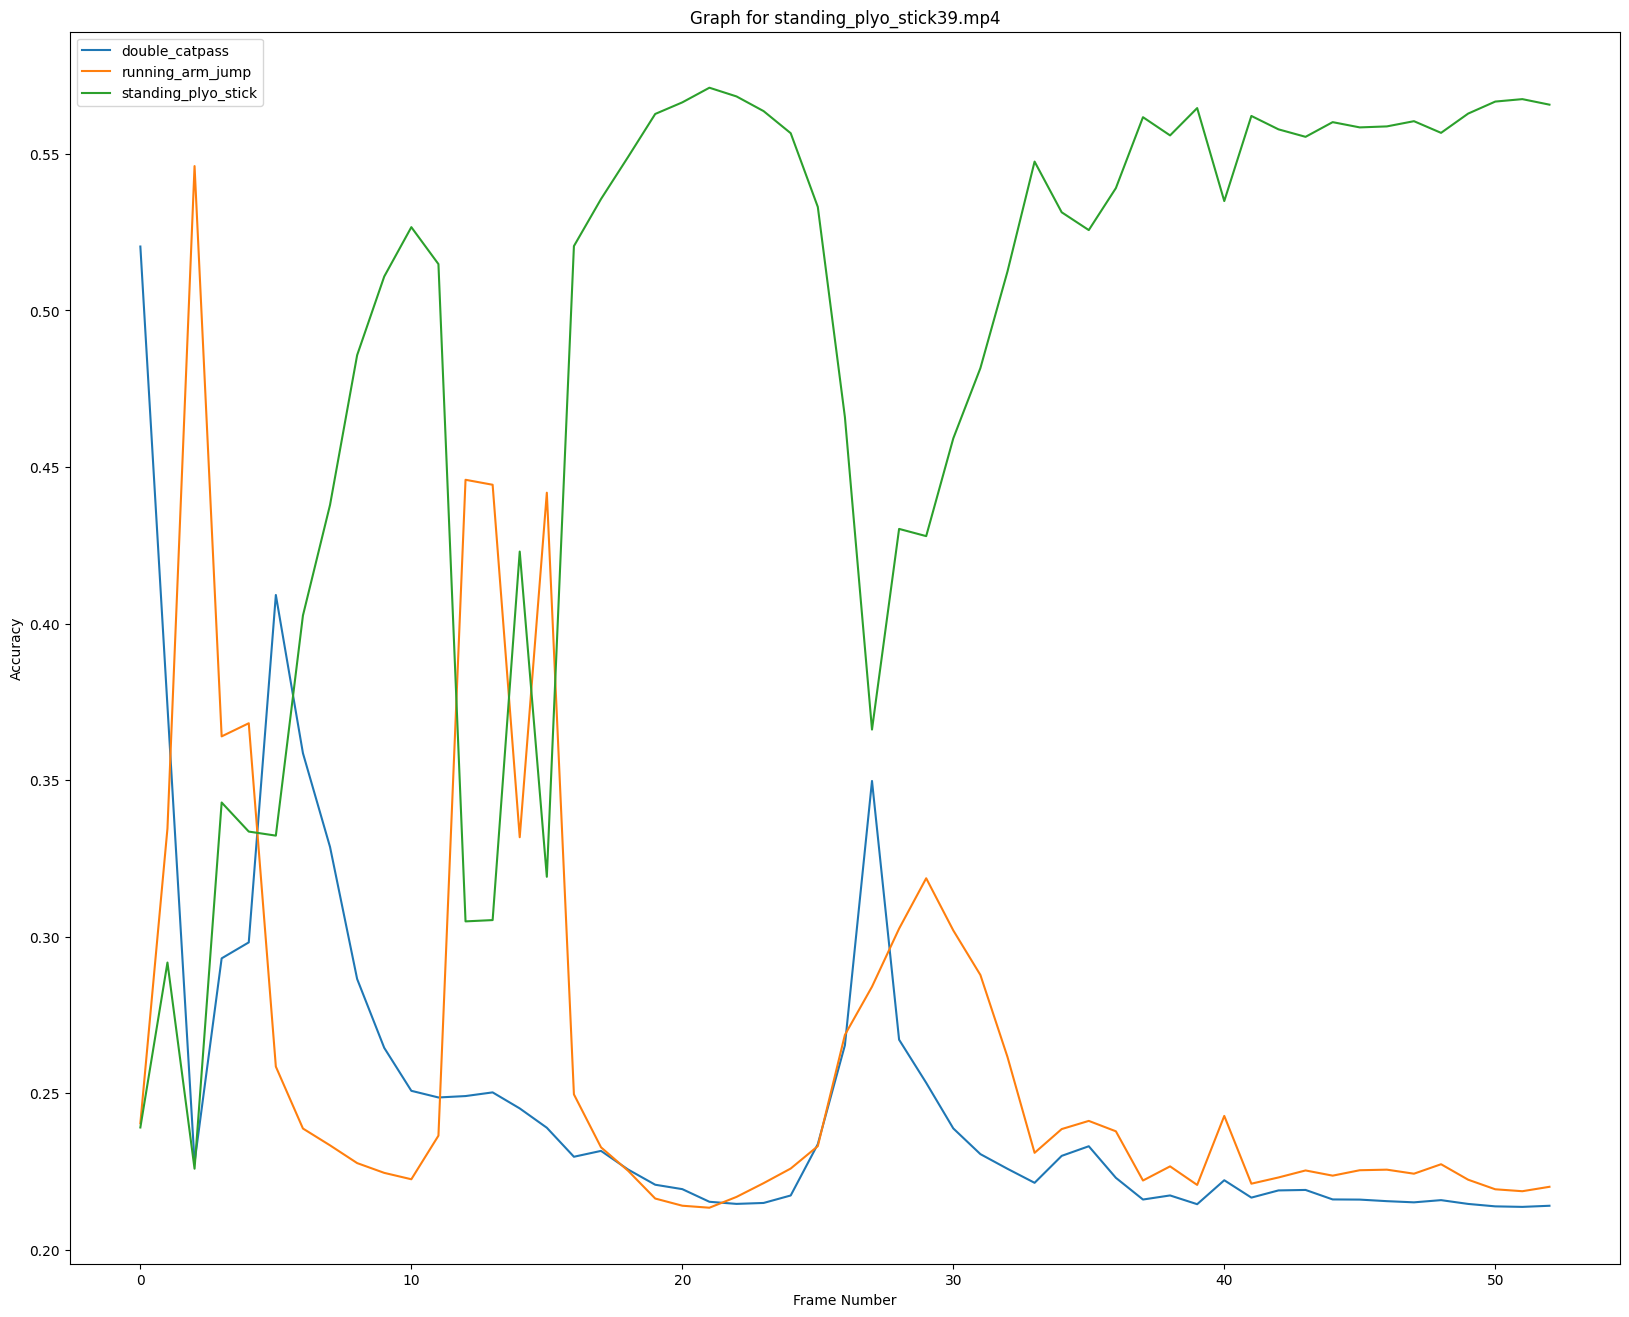

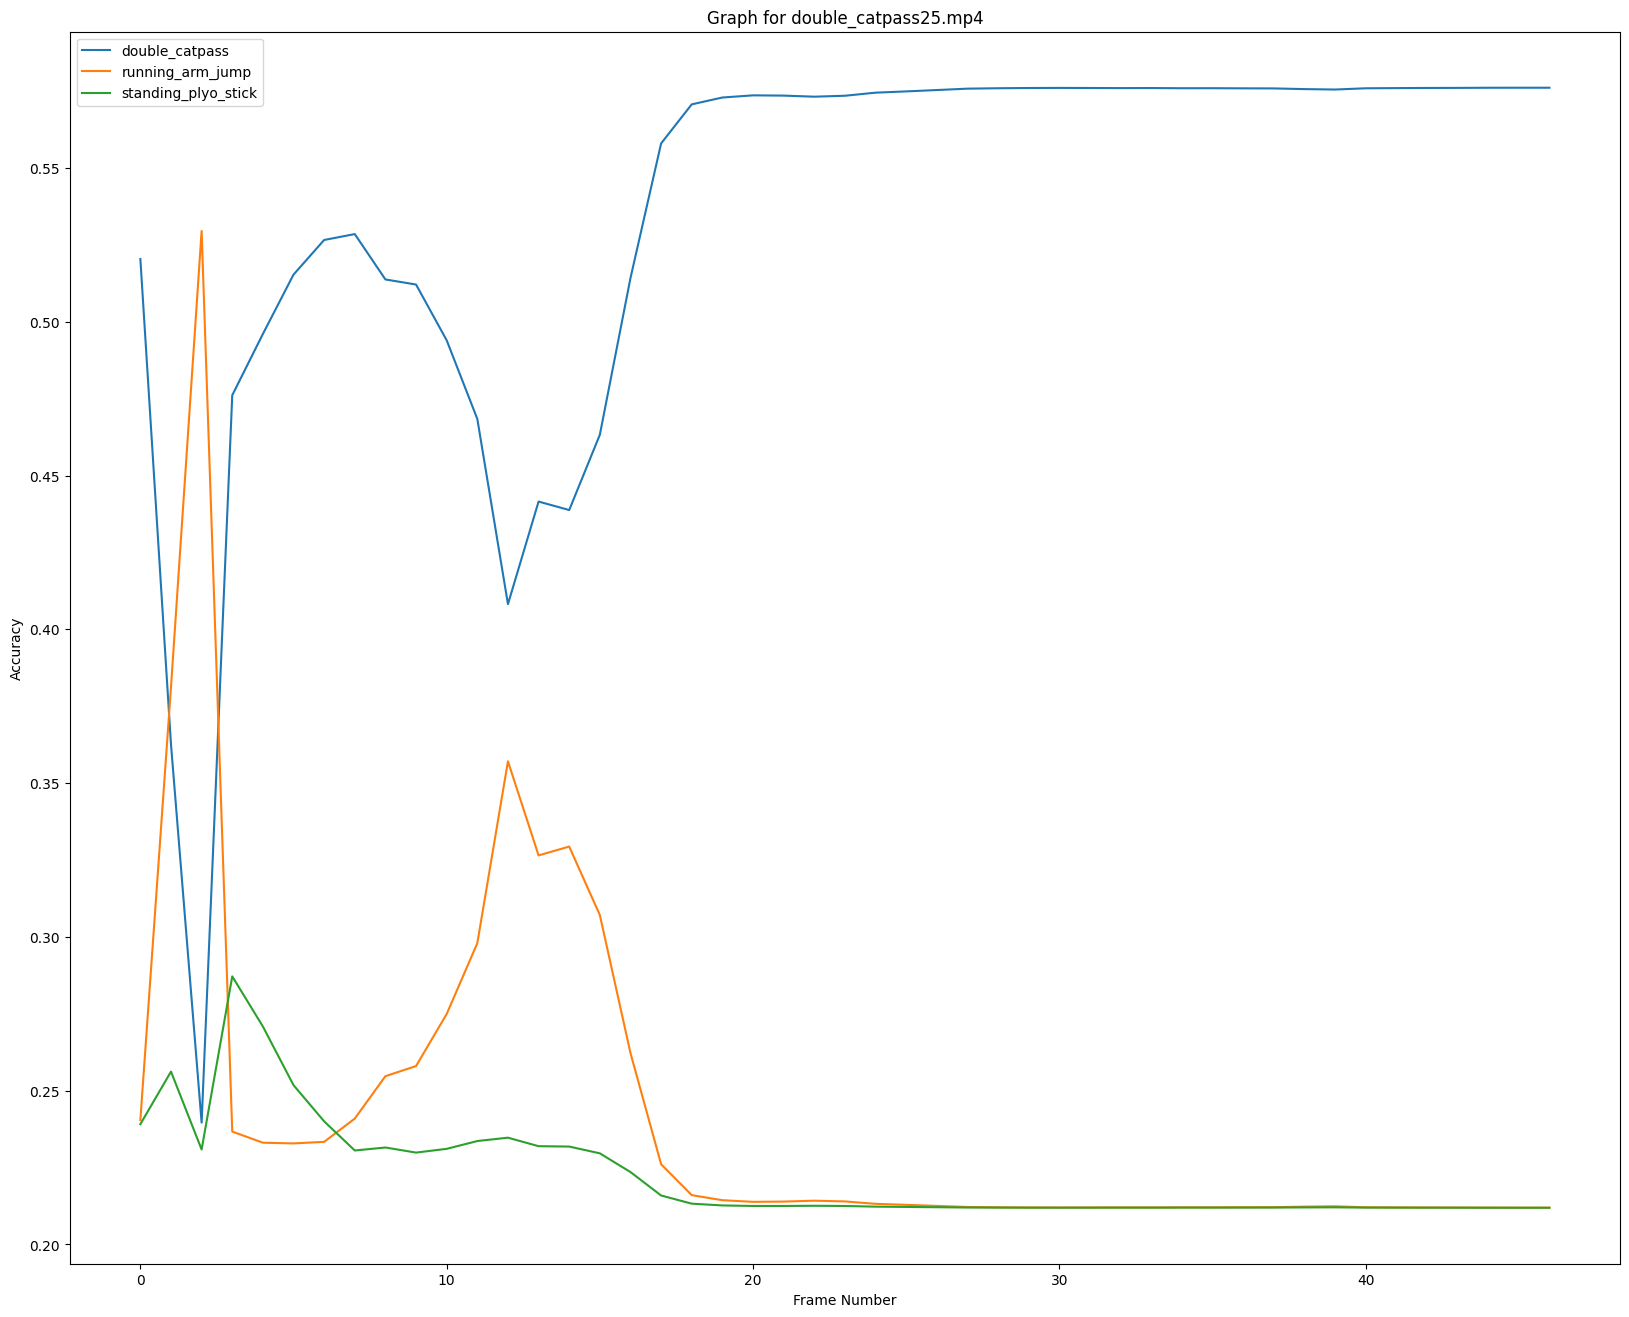

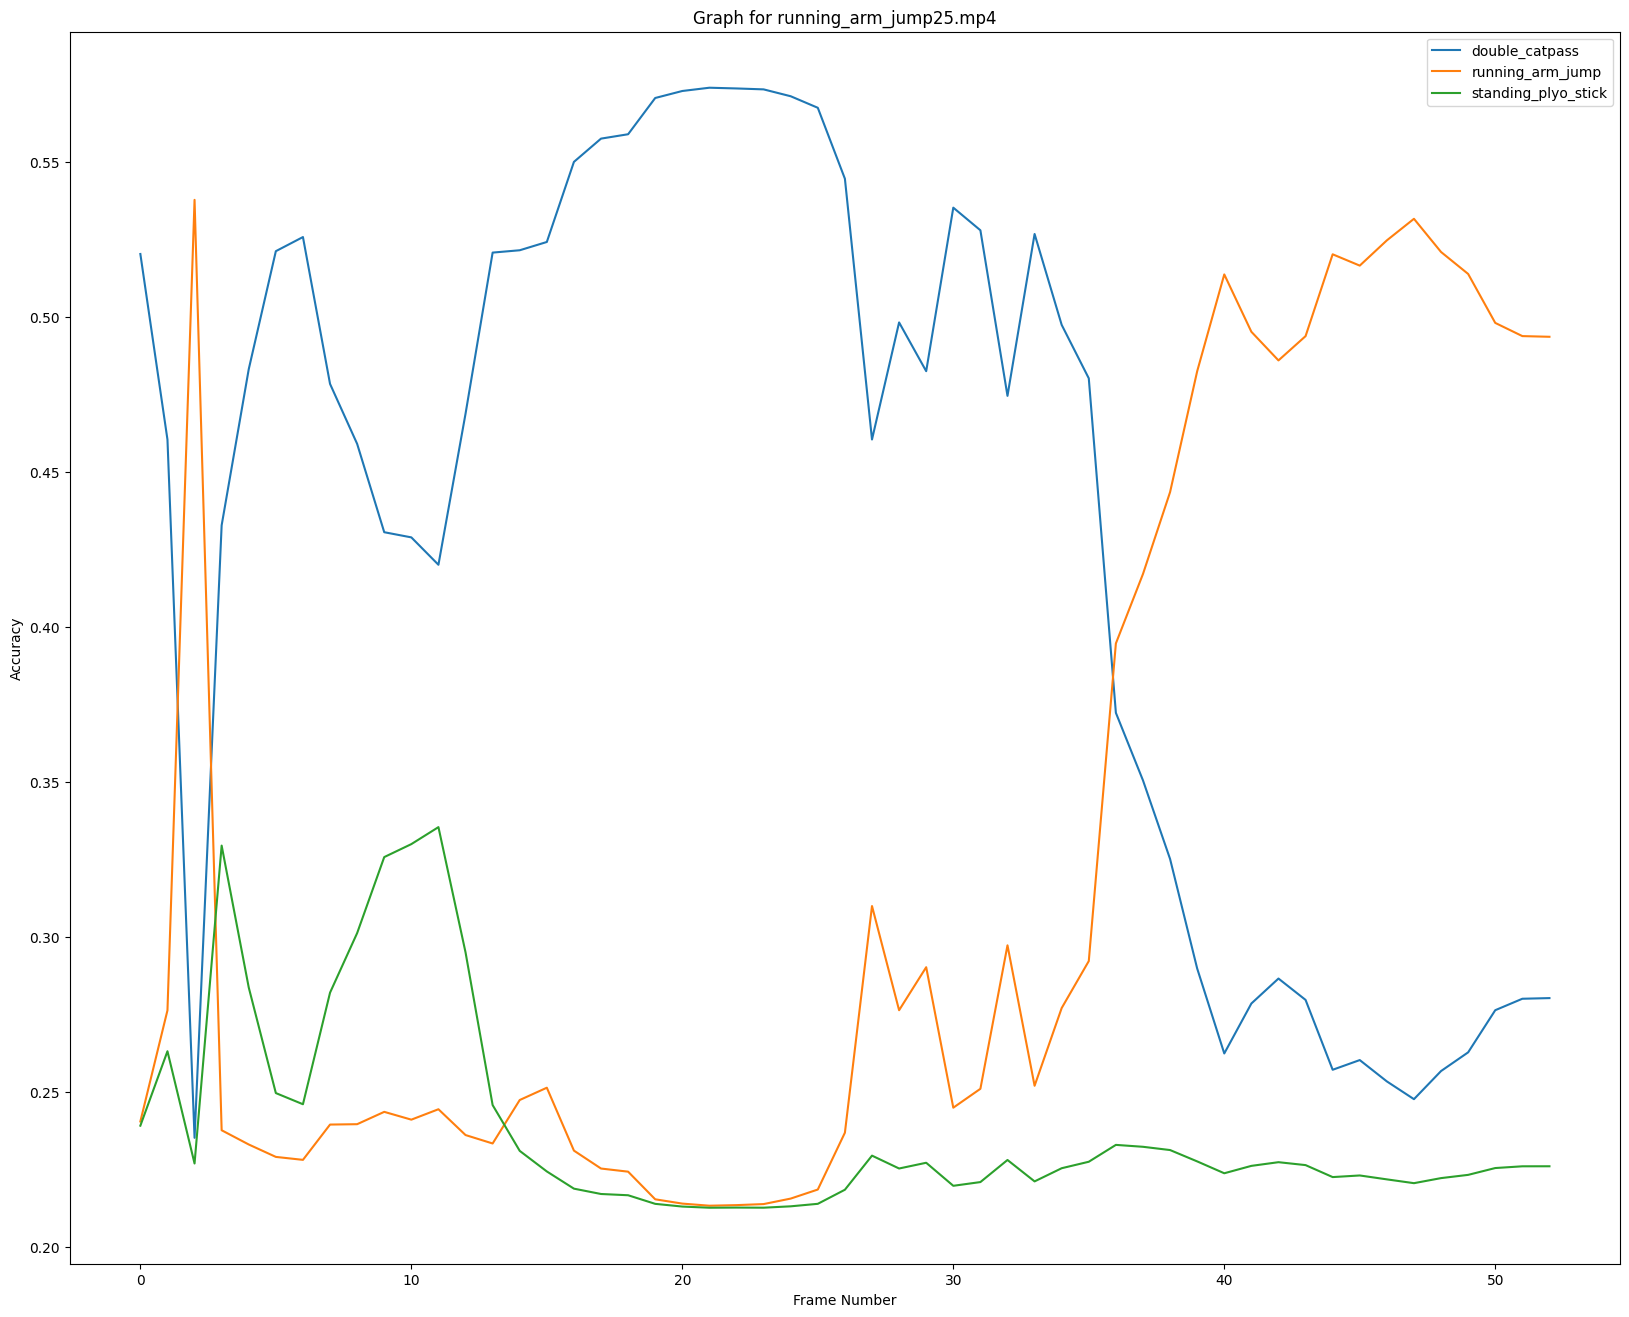

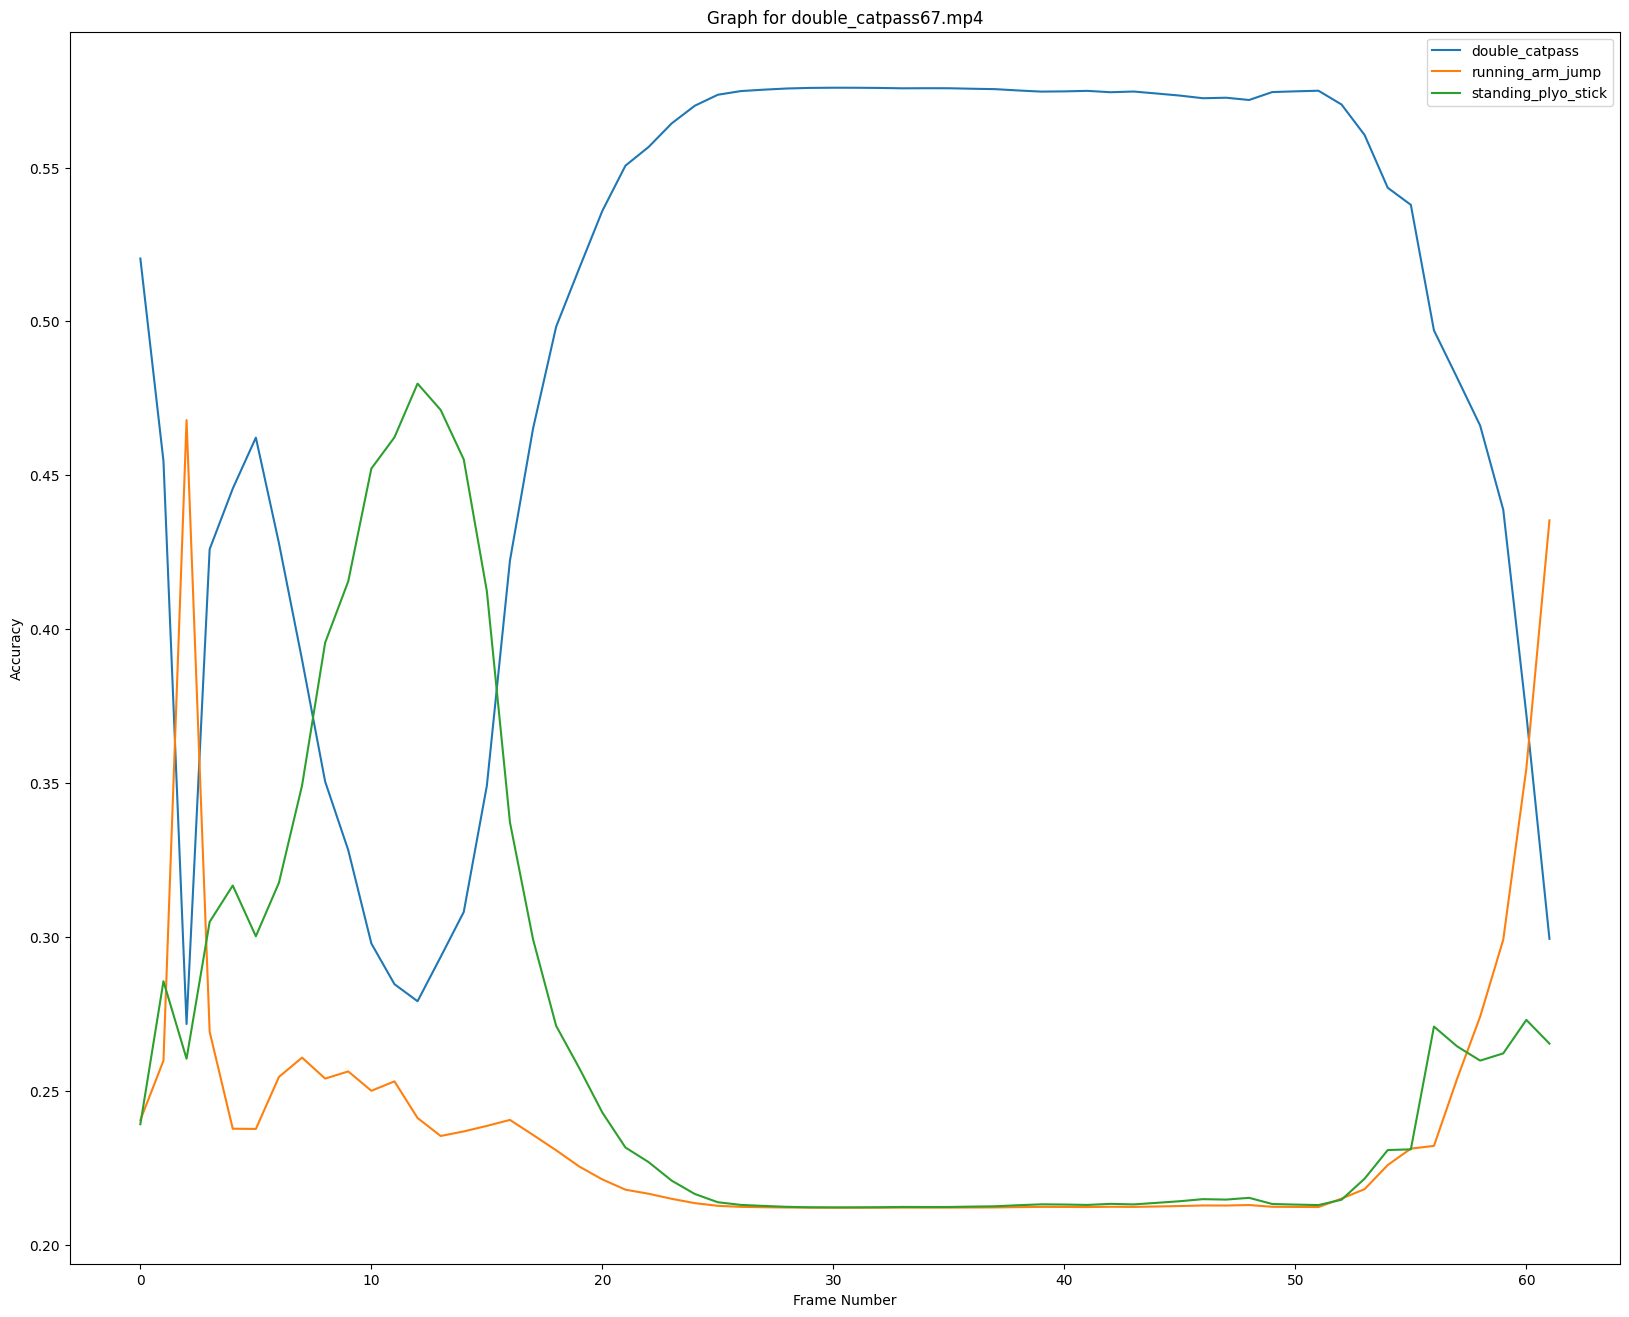

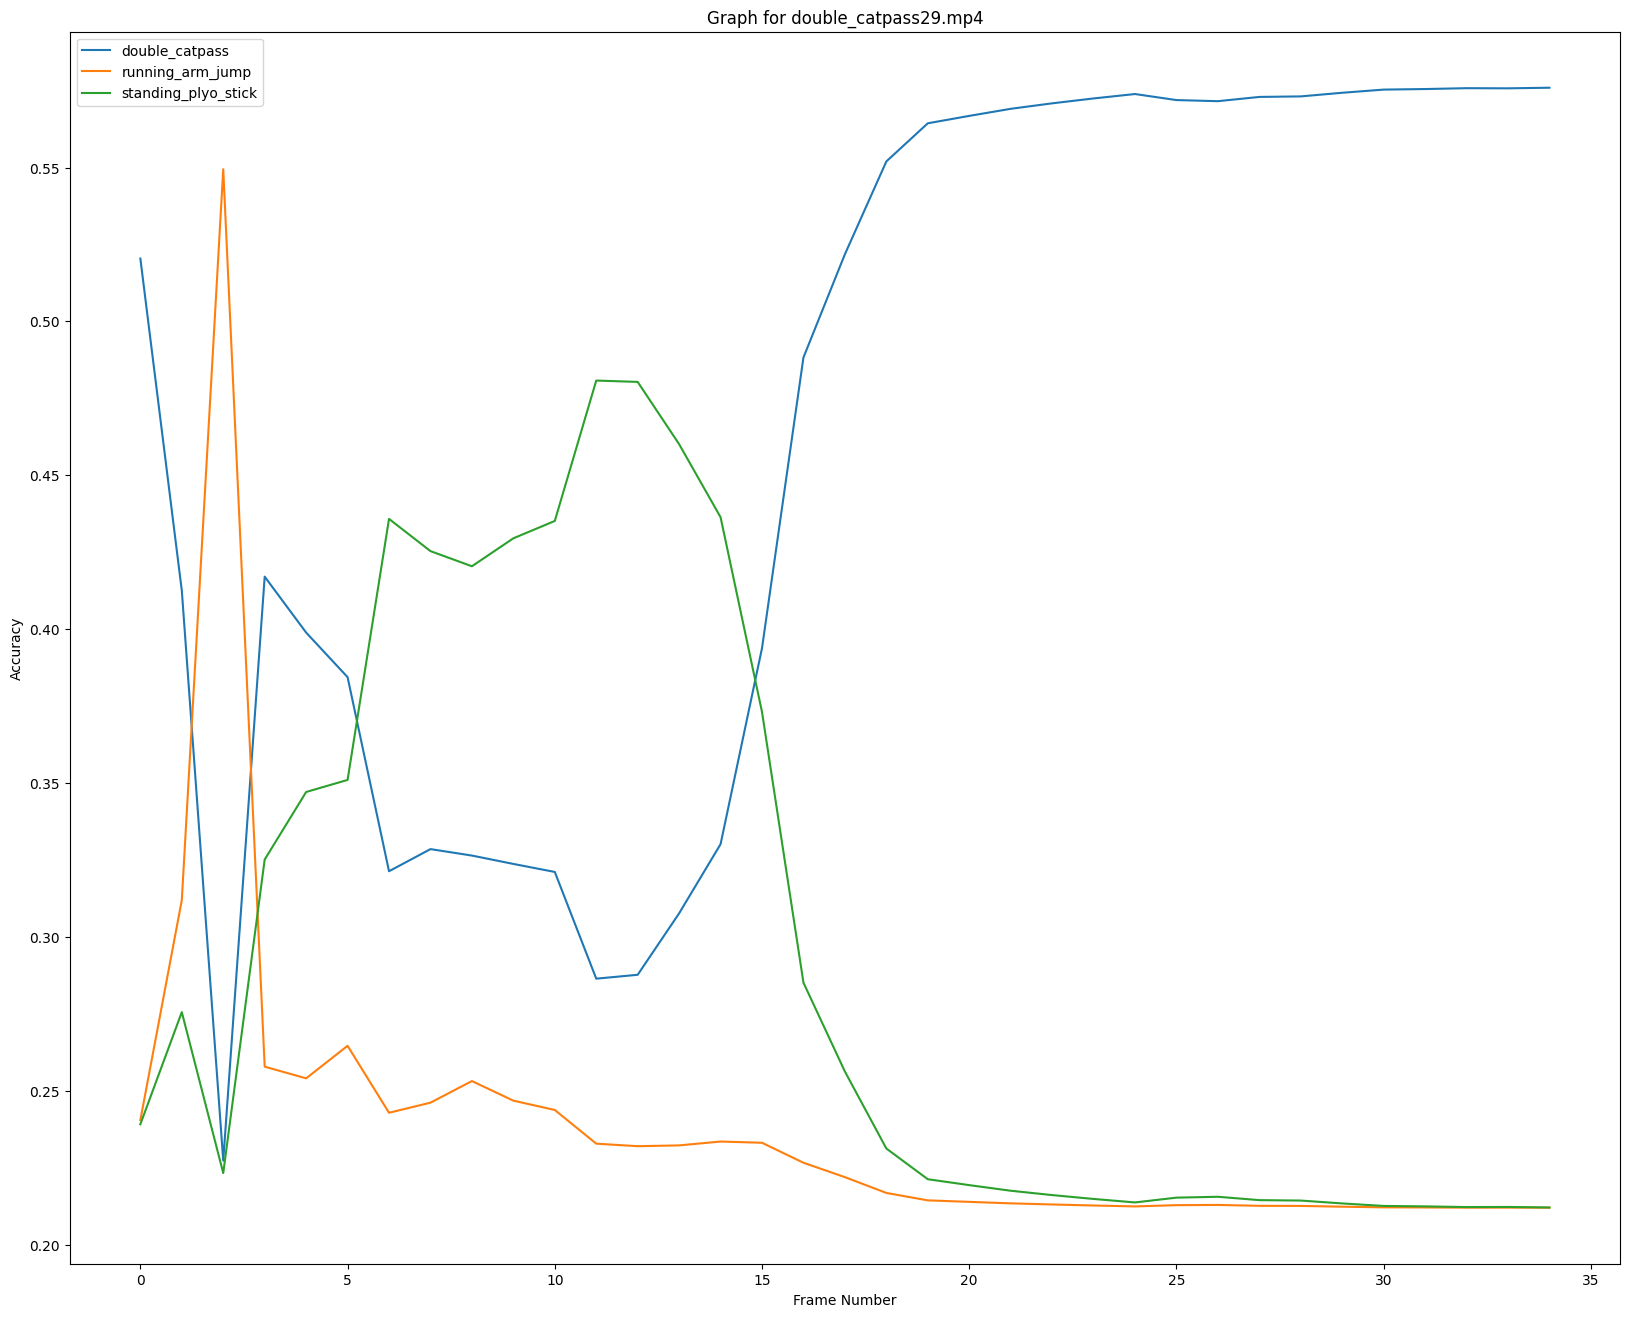

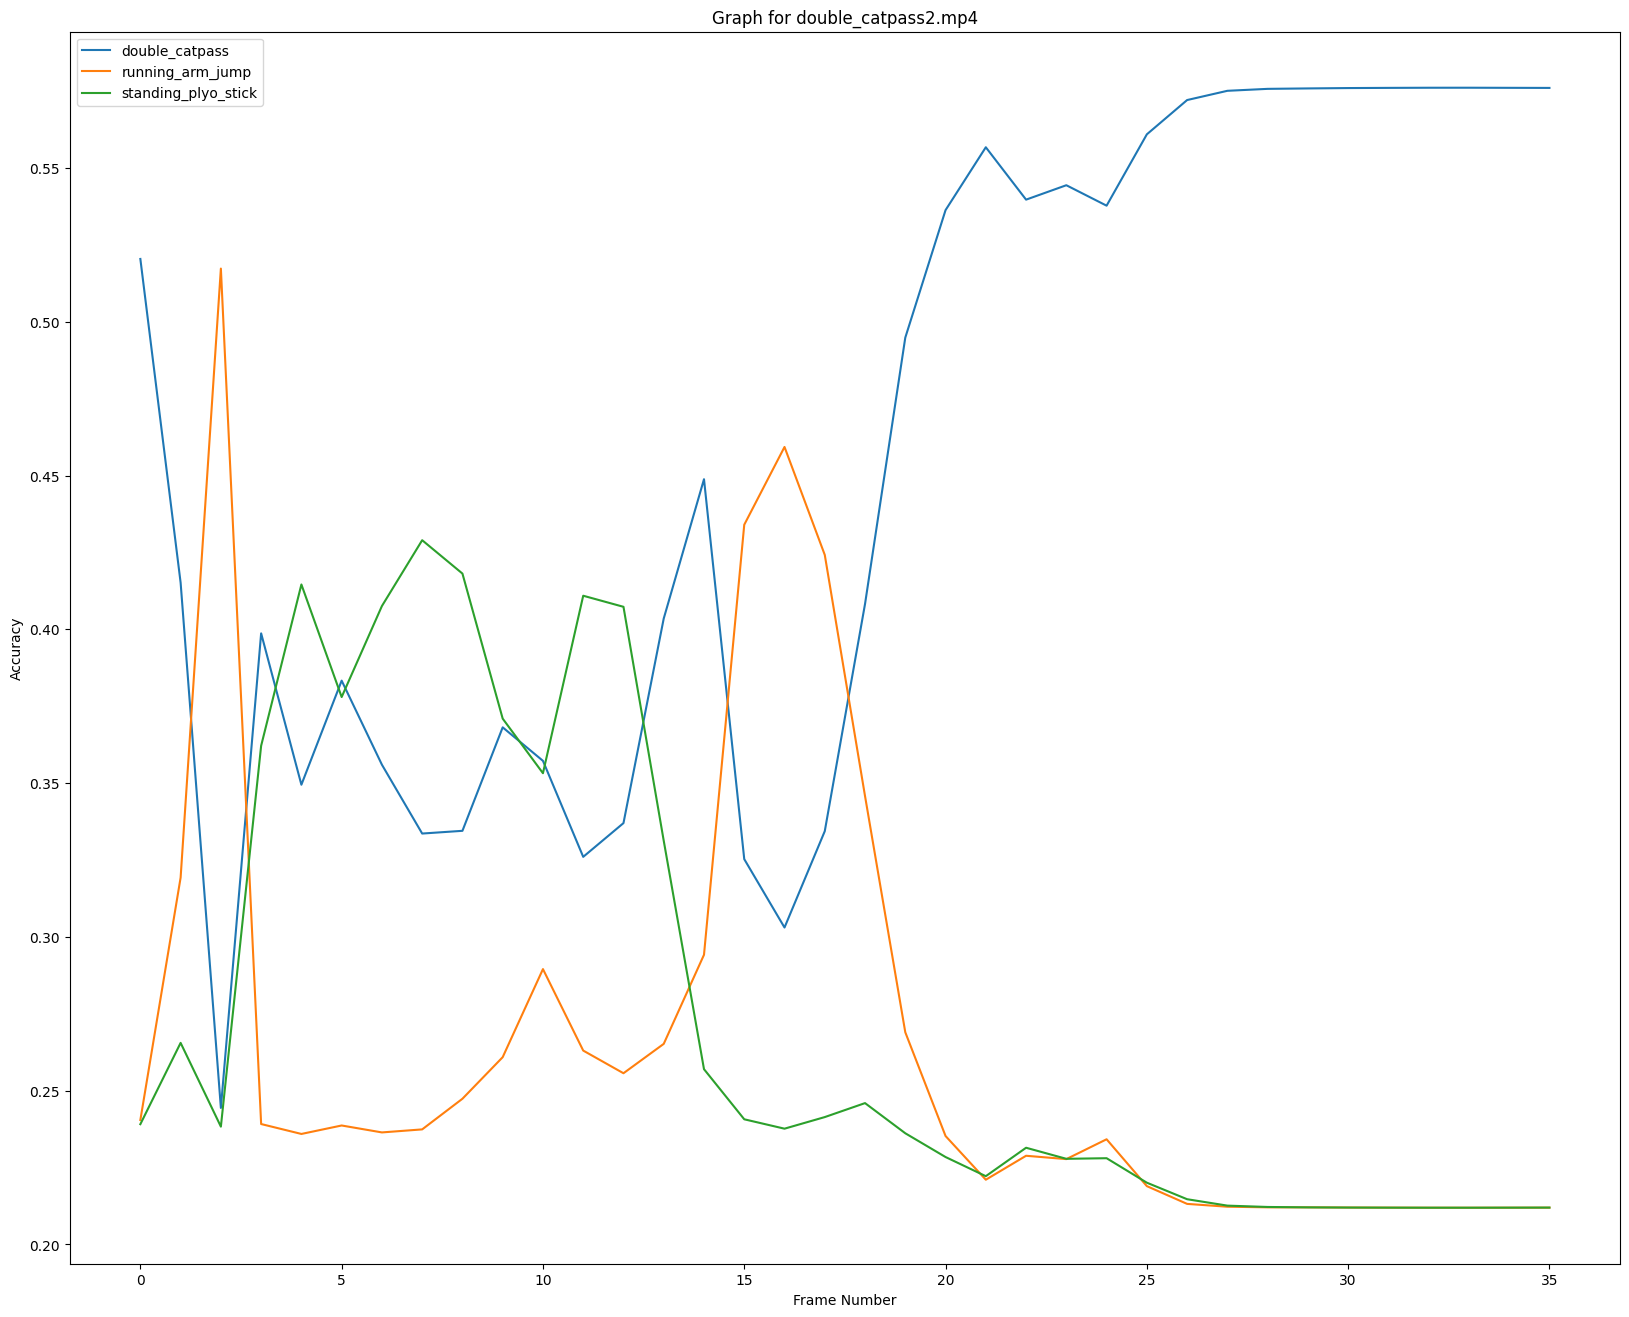

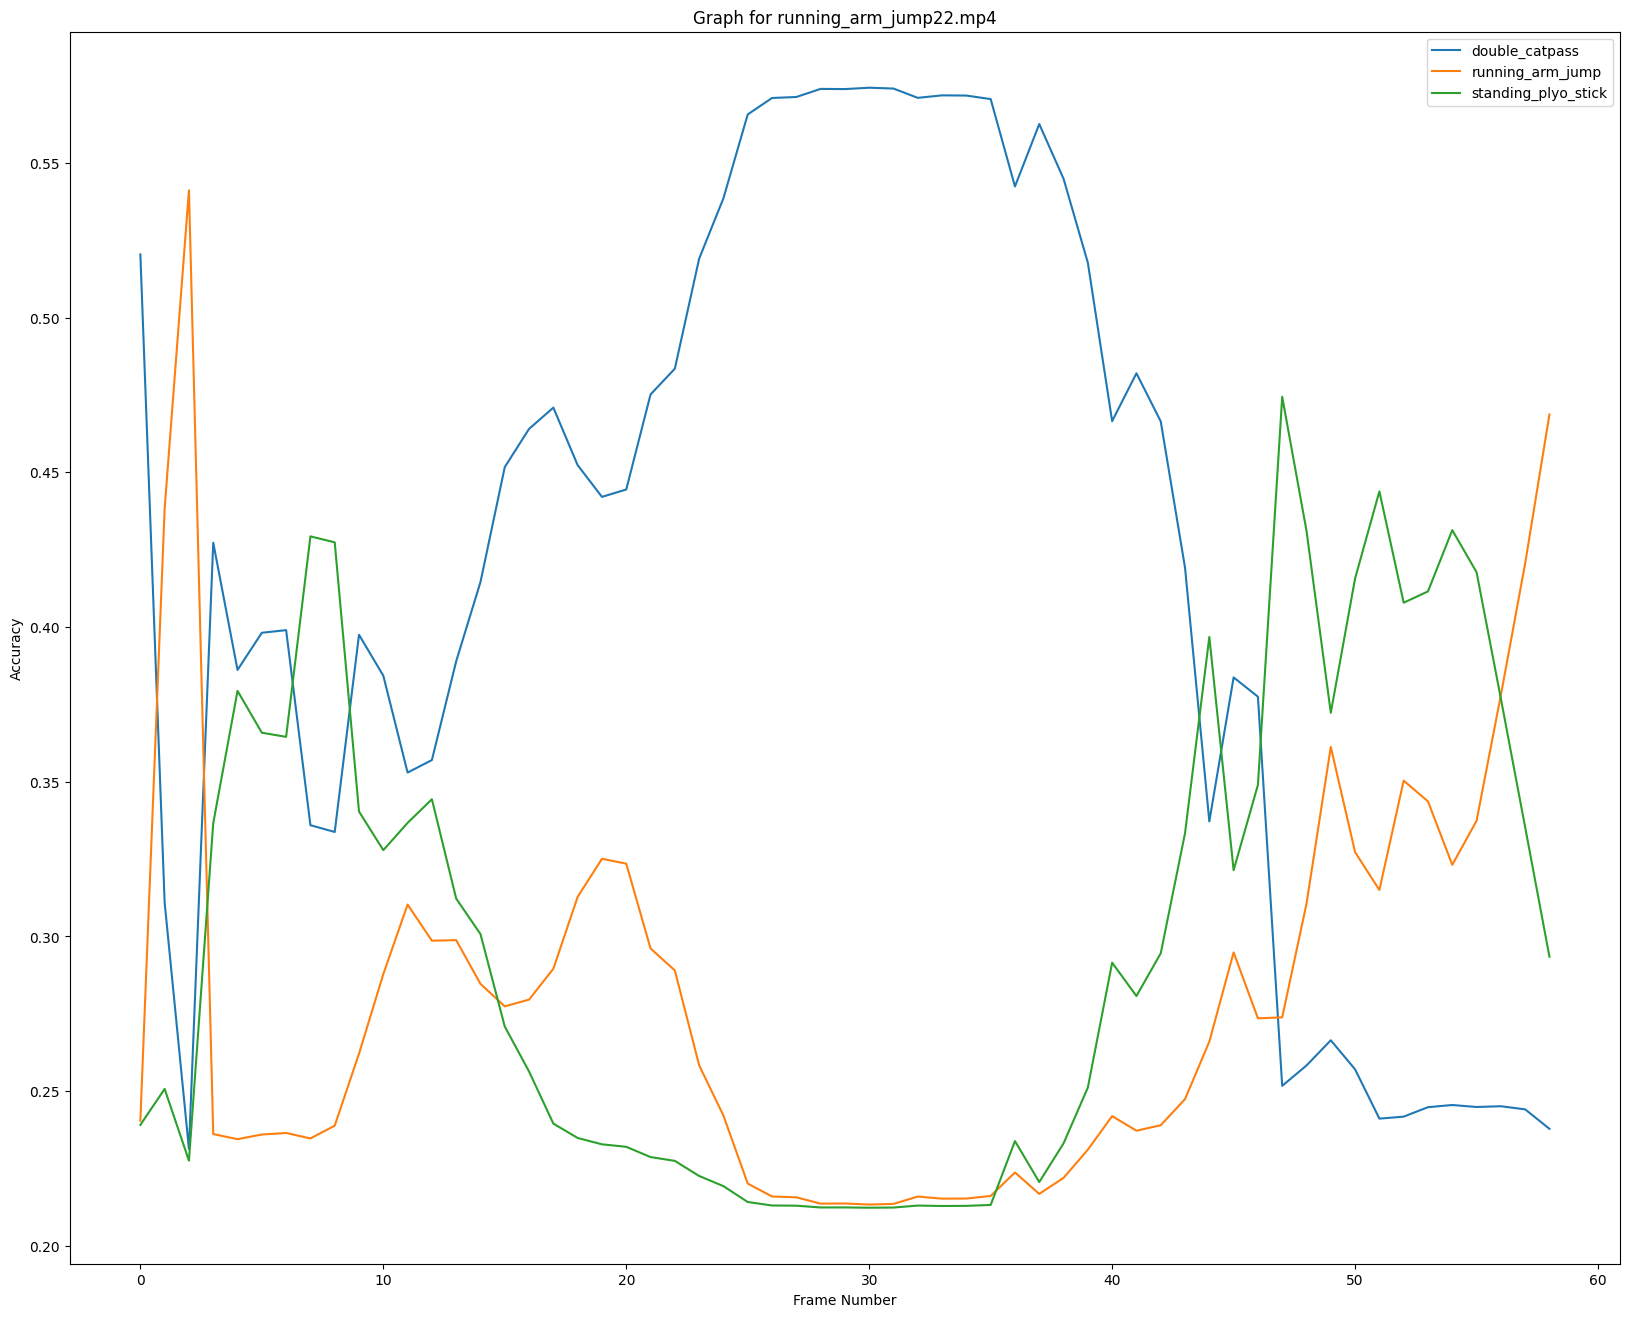

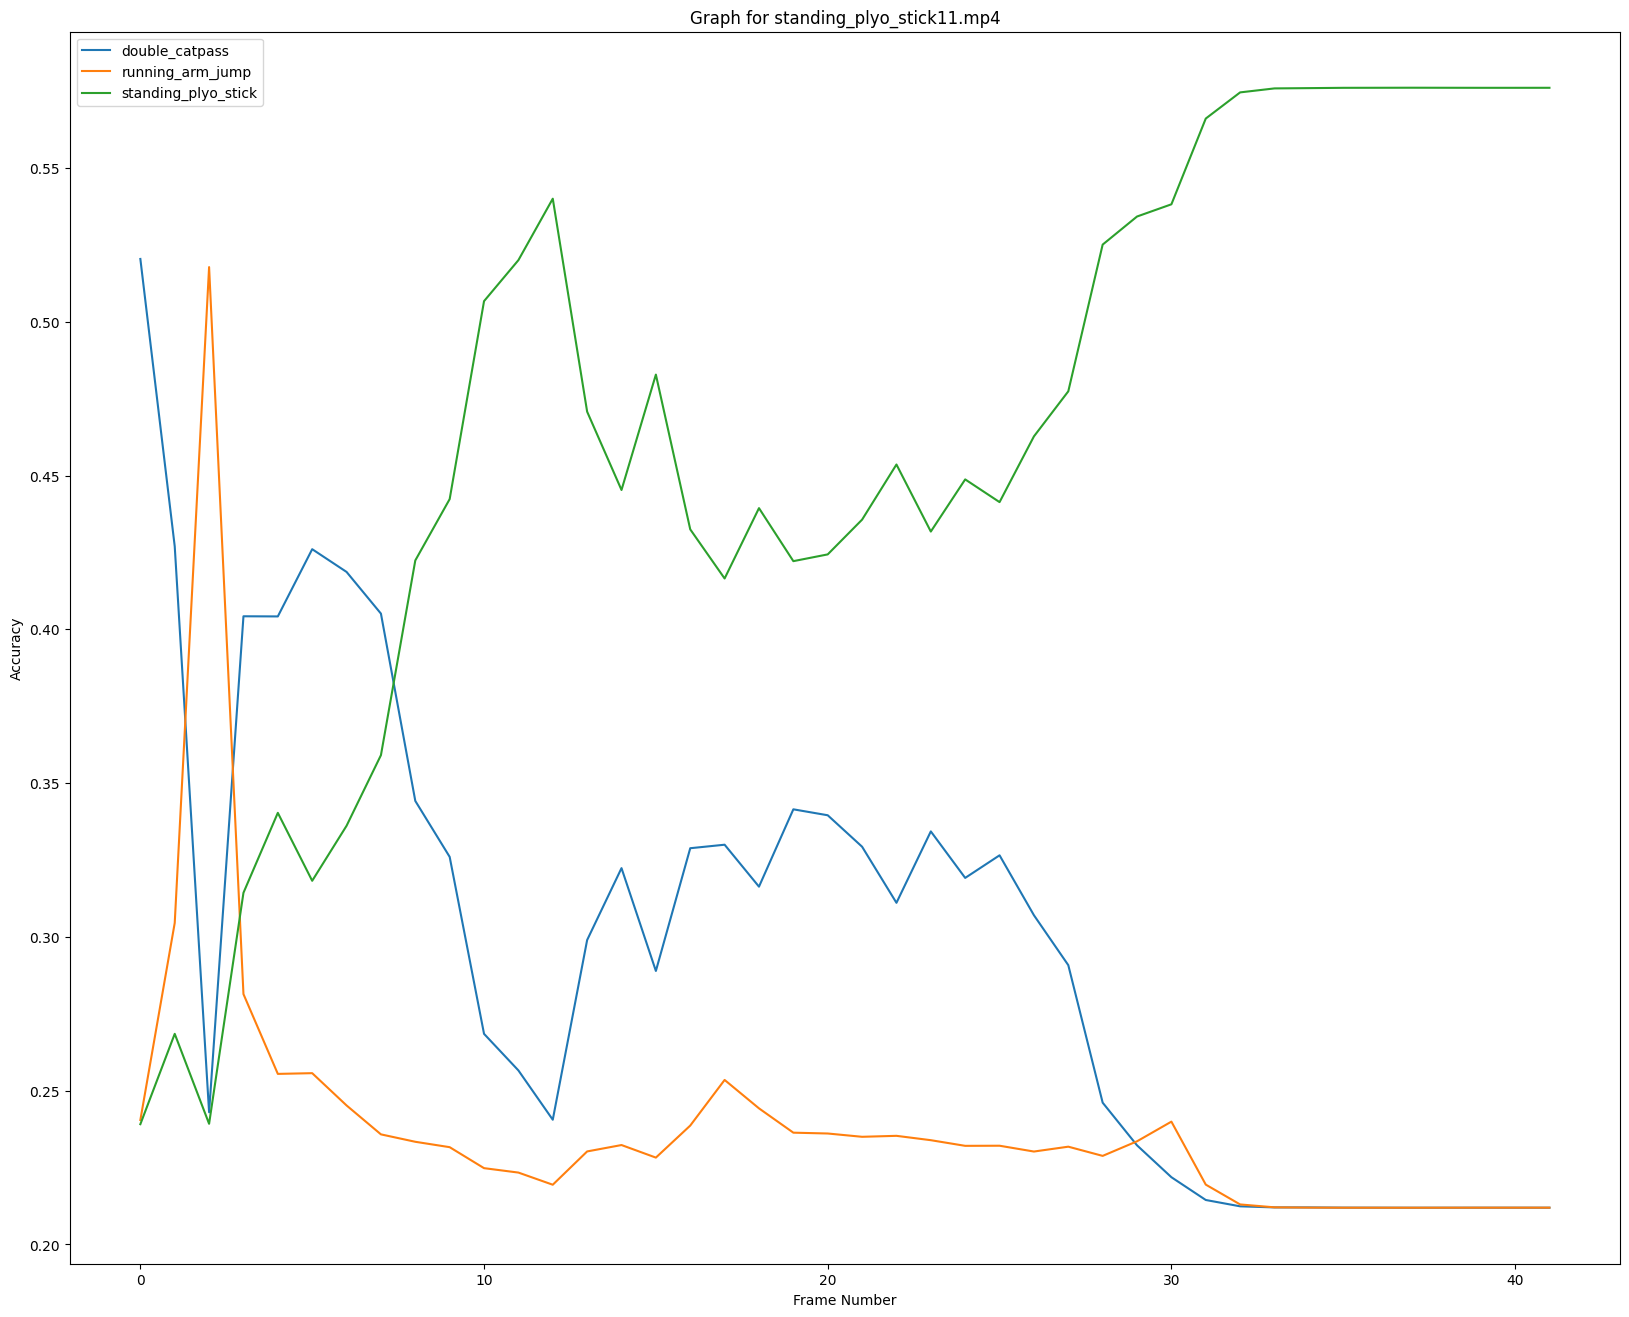

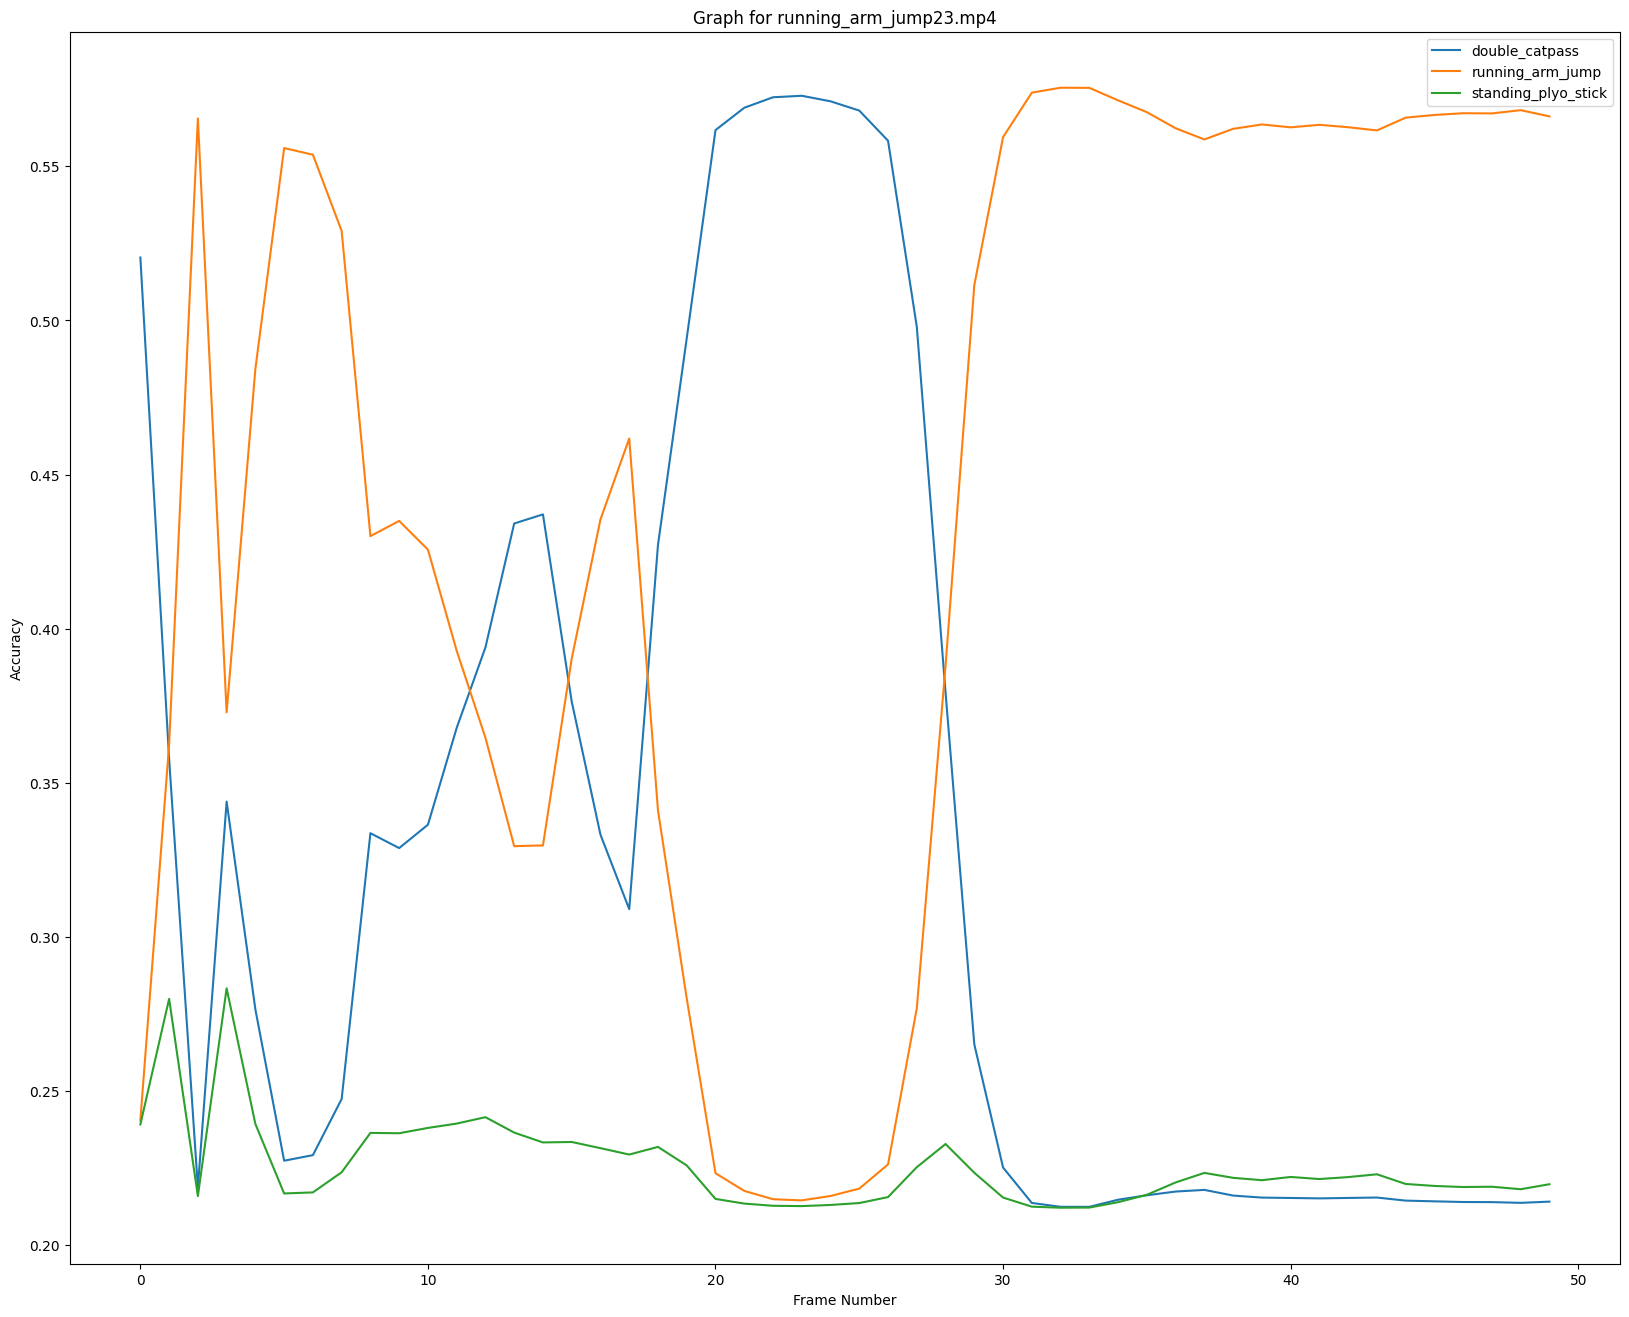

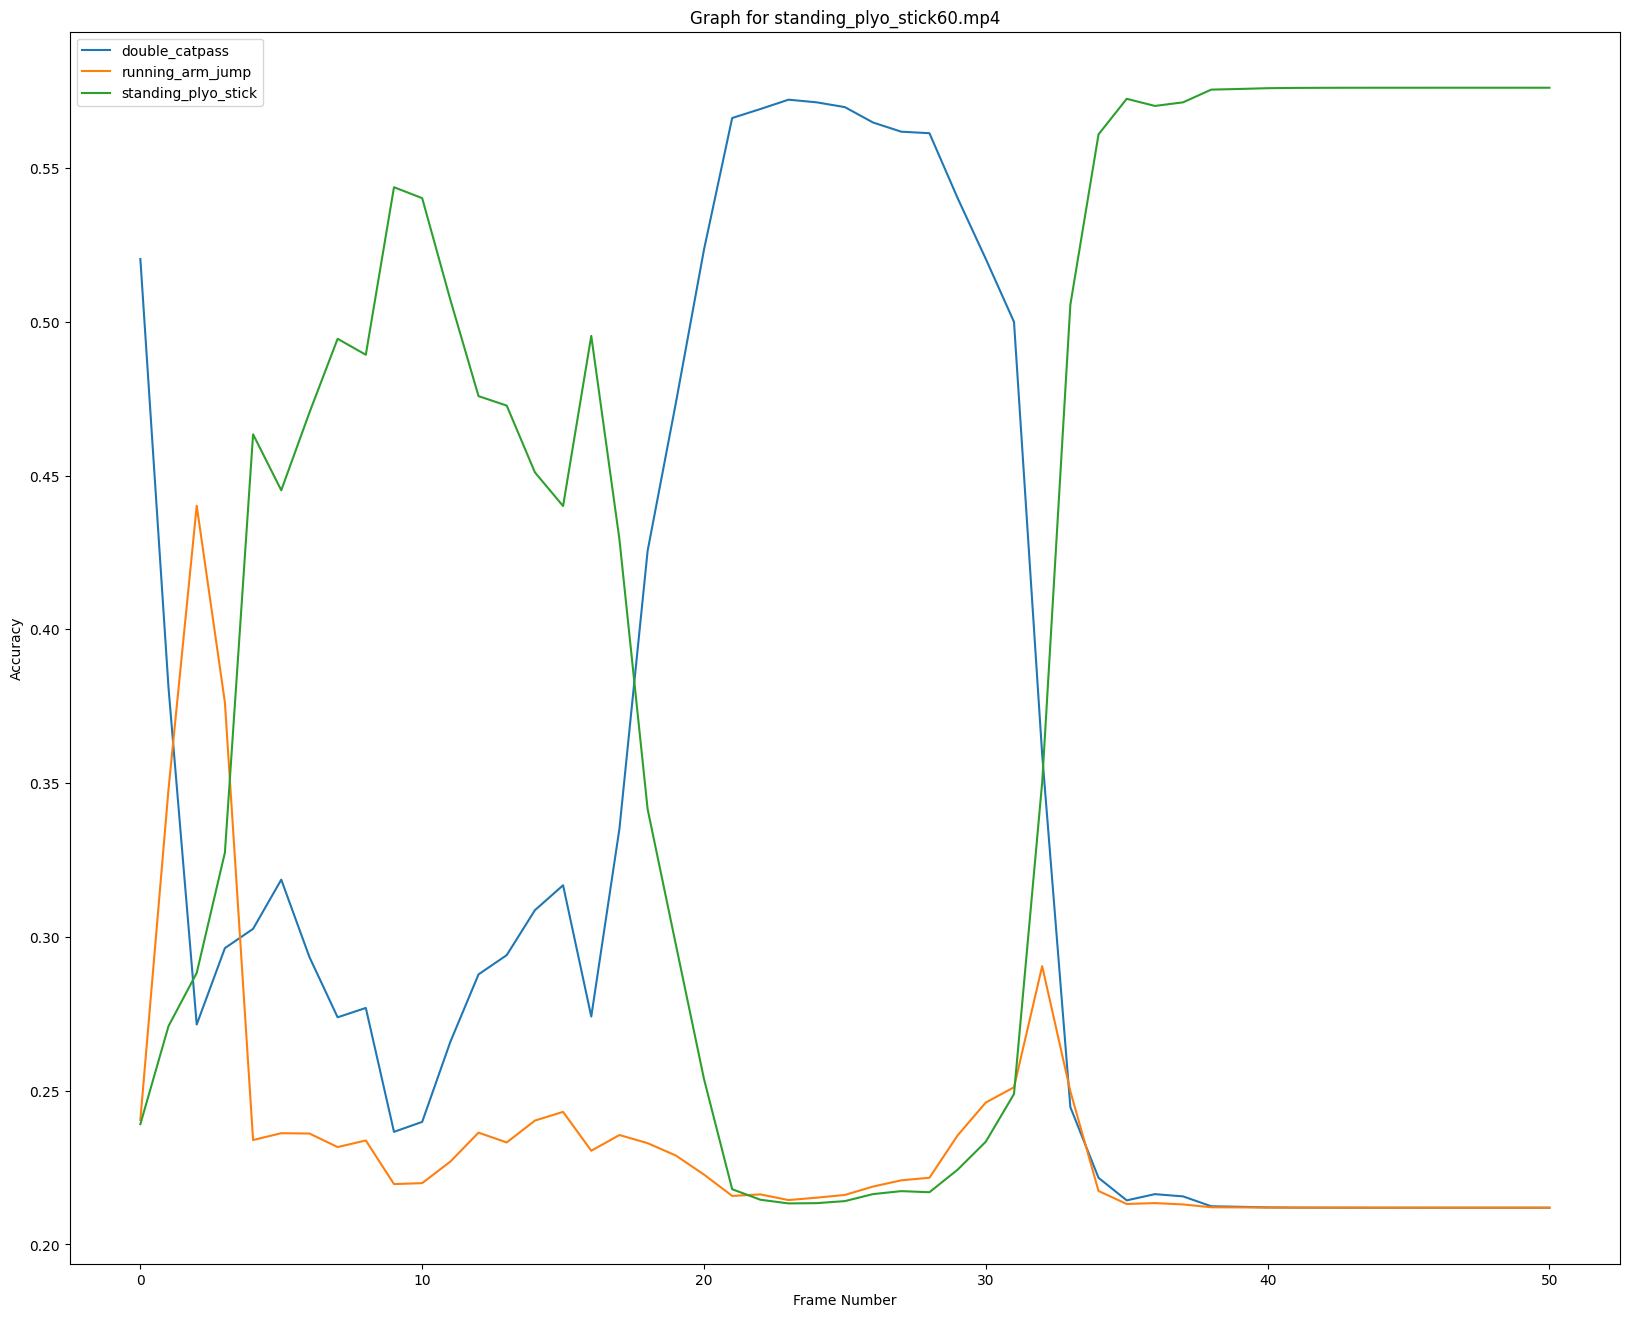

In [31]:
labels = list(y_test)
accuracy_array = rep_counter_accuracy(test_files, str(datetime.now().strftime("%d-%m-%Y-%H-%M-%S.txt")))

In [32]:
similarity_percentage = similarity(labels, accuracy_array)

In [33]:
print(labels)
print(accuracy_array)
print(similarity_percentage)

[2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2]
[2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2]
88.88888888888889


[Text(0.5, 1.0, 'Confusion Matrix of Frame Prediction Accuracy')]

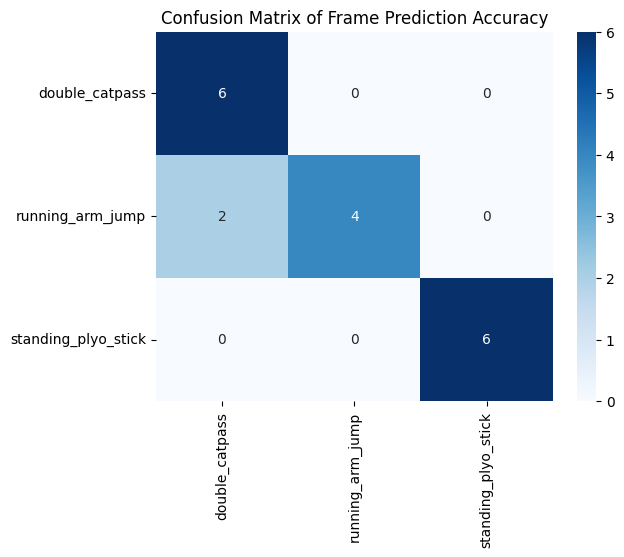

In [34]:
confusion_matrix = sklearn.metrics.confusion_matrix(labels, accuracy_array)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names).set(title="Confusion Matrix of Frame Prediction Accuracy")